<a href="https://colab.research.google.com/github/underthelights/recsys_hnm/blob/main/%5BRecSys%5D_H%26M_Data_Analysis_%26_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<a id="Content" style="color:#023e8a;">Table of Content</a>**
* [**<span style="color:#023e8a;">1. Dataset</span>**](#Dataset)  
* [**<span style="color:#023e8a;">2. Articles</span>**](#Articles)  
* [**<span style="color:#023e8a;">3. Customers</span>**](#Customers)  
* [**<span style="color:#023e8a;">4. Transactions</span>**](#Transactions)  
* [**<span style="color:#023e8a;">5. Recommender System</span>**](#Recommendation)  

## **<span id="Dataset" style="color:#023e8a;">1. Dataset</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)


🛍️ **There are 3 metadata .csv files and 1 image file:**
* 📸 `images` - images of every article_id
* 🙋 `articles`  - detailed metadata of every article_id **(105,542 datapoints)**
* 👔 `customers`  - detailed metadata of every customer_id **(1,371,980 datapoints)**
* 🧾 `transactions_train`  - file containing the `customer_id`, the article that was bought and at what price **(31,788,324 datapoints)**

**<span style="color:#023e8a;"> The first step as always: load the data :)</span>**


### ⬇ Libraries

Notebook Color Scheme:


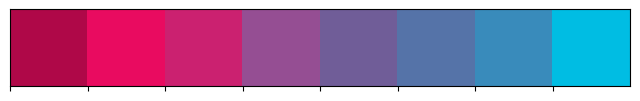

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import warnings
import glob
import gc
from wordcloud import WordCloud, STOPWORDS

plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'

my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

# bk_image = plt.imread("../input/hm-fashion-recommender-dataset/background.jpg")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/(2023-7) Sogang_2023_2/RecSys/Term_Prj'

/content/drive/MyDrive/Lifes/(2019~2023) BS.c. @ Sogang U/(2023-7) Sogang_2023_2/RecSys/Term_Prj


In [4]:
data_dir = "./"
image_dir = '../images/*/*'

In [5]:
transactions = pd.read_csv(data_dir + 'transactions_train.csv')

In [6]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


Memory Efficieny

In [7]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['year'] = (transactions['t_dat'].dt.year-2000).astype('int8')
transactions['month'] = (transactions['t_dat'].dt.month).astype('int8')
transactions['day'] = (transactions['t_dat'].dt.day).astype('int8')
transactions.drop('t_dat', axis=1, inplace=True)
transactions['price'] = transactions['price'].astype('float32')
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('int8')
# transactions['article_id'] = transactions['article_id'].astype('int32')

In [8]:
articles = pd.read_csv(data_dir + 'articles.csv')

In [9]:
customers = pd.read_csv(data_dir + 'customers.csv')

**<span style="color:#023e8a;"> Let's look at the tables and try to get some outcomes about data inside.</span>**

Lets take a closer look at the data

There are 3 main tables:
- **articles** - contains informations about each article (like product code, name, product group code, name ...)    
- **customers** - contains informations about each customer (fidelity card membership, age, postal code)
- **transactions** (train)  

Transactions have `customer_id` and `article_id`, which are foreign keys for the customer and articles tables.
Beside this, transaction also contains `sales_channel_id`.

## **<span id="Articles" style="color:#023e8a;">2. Articles</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)


**<span style="color:#023e8a;"> This table contains all h&m articles with details such as a type of product, a color, a product group and other features.</span>**  
**<span style="color:#023e8a;"> Article data description: </span>**

> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article.</span>**  
> `product_code`, `prod_name` **<span style="color:#023e8a;">: A unique identifier of every product and its name (not the same).</span>**  
> `product_type`, `product_type_name` **<span style="color:#023e8a;">: The group of product_code and its name</span>**  
> `graphical_appearance_no`, `graphical_appearance_name` **<span style="color:#023e8a;">: The group of graphics and its name</span>**  
> `colour_group_code`, `colour_group_name` **<span style="color:#023e8a;">: The group of color and its name</span>**  
> `perceived_colour_value_id`, `perceived_colour_value_name`, `perceived_colour_master_id`, `perceived_colour_master_name` **<span style="color:#023e8a;">: The added color info</span>**  
> `department_no`, `department_name`: **<span style="color:#023e8a;">: A unique identifier of every dep and its name</span>**  
> `index_code`, `index_name`: **<span style="color:#023e8a;">: A unique identifier of every index and its name</span>**  
> `index_group_no`, `index_group_name`: **<span style="color:#023e8a;">: A group of indeces and its name</span>**  
> `section_no`, `section_name`: **<span style="color:#023e8a;">: A unique identifier of every section and its name</span>**  
> `garment_group_no`, `garment_group_name`: **<span style="color:#023e8a;">: A unique identifier of every garment and its name</span>**  
> `detail_desc`: **<span style="color:#023e8a;">: Details</span>**  

## I. Preprocessing

🛍️ **Important Notes**:
* There are *more* `article_ids` than actual images:
    * unique article ids: 105,542
    * unique images: 105,100
* The `path` processing was taking too long, so the fastest (takes 1 second) way to do it was to create a variable that contains all article ids within the `images` folder (remember, `set()` is faster than a `list`), and then to correct any path that was invalid within the `articles.csv` file.
* There are only 416 missing values within the `desc` column - product description

In [11]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
articles.head()

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [14]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
      articles.isna().sum()[-1], "total missing values")

# Replace missing values
articles.fillna(value="No Description", inplace=True)

There are no missing values in any columns but 'Detail Description': 0 total missing values


In [15]:
# Get all paths from the image folder
all_image_paths = glob.glob(image_dir)

print(clr.S+"Number of unique article_ids within articles.csv:"+clr.E, len(articles), "\n"+
      clr.S+"Number of unique images within the image folder:"+clr.E, len(all_image_paths), "\n"+
      clr.S+"=> not all article_ids have a corresponding image!!!"+clr.E, "\n")

# Get all valid article ids
# Create a set() - as it moves faster than a list
all_image_ids = set()

for path in tqdm(all_image_paths):
    article_id = path.split('/')[-1].split('.')[0]
    all_image_ids.add(article_id)

Number of unique article_ids within articles.csv: 105542 
Number of unique images within the image folder: 0 
=> not all article_ids have a corresponding image!!! 



0it [00:00, ?it/s]

## II. Explore

**<span style="color:#023e8a;">Ladieswear accounts for a significant part of all dresses. Sportswear has the least portion.</span>**

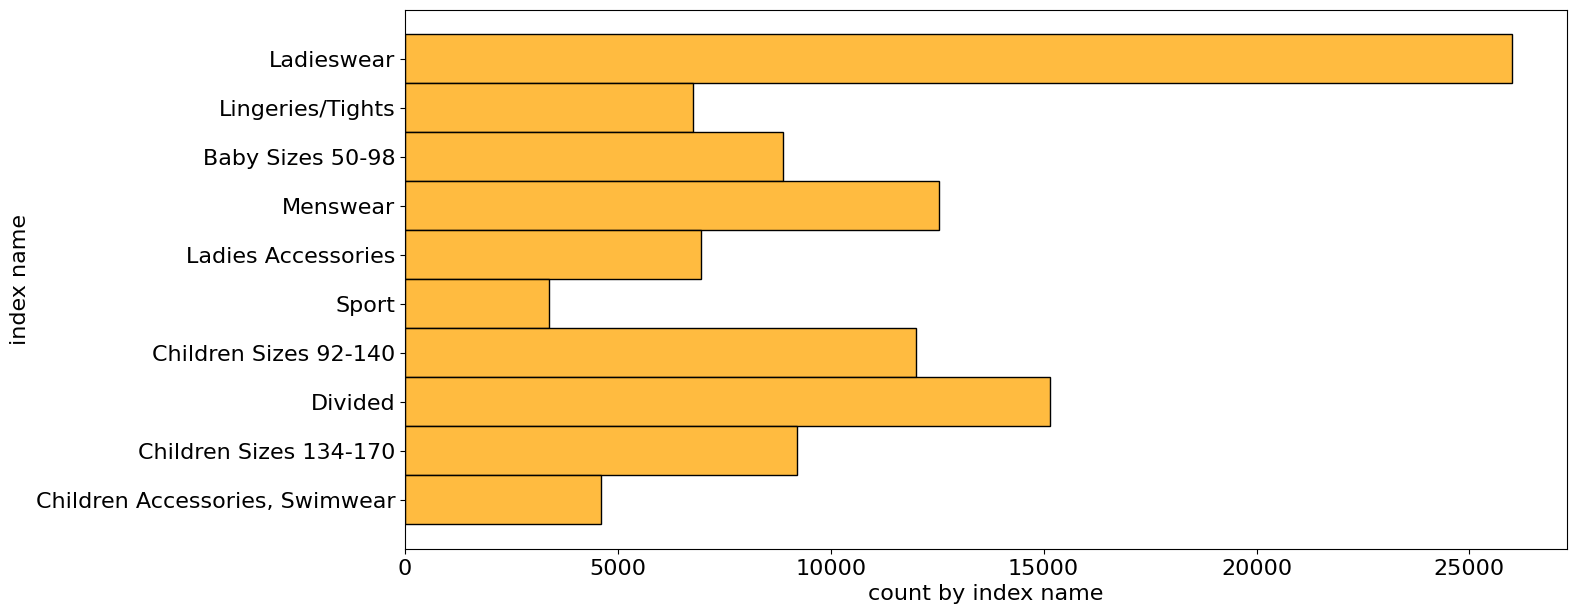

In [16]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name', color='orange')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

**<span style="color:#023e8a;"> The garments grouped by index: Jersey fancy is the most frequent garment, especially for women and children. The next by number is accessories, many various accessories with low price.</span>**

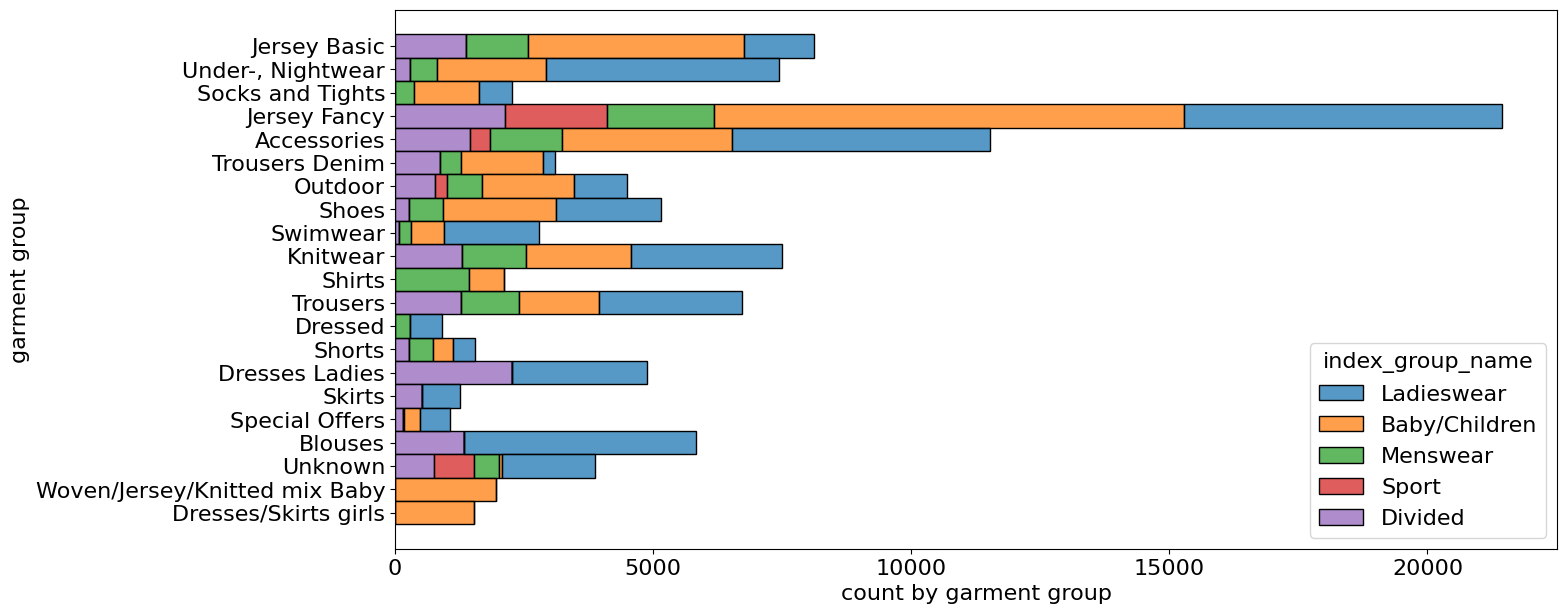

In [17]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

In [18]:
label = articles.index_group_name.unique()
count1 = articles.index_group_name.value_counts()
fig = px.pie(articles, values=count1, title="Pie Chart on Type on Products", names=label,color_discrete_sequence=px.colors.sequential.Purpor)
fig.show()

[link text](https:// [link text](https://))
**<span style="color:#023e8a;">Most sold product is the Dragonfly dress.</span>**

Total Number of unique Product Names: 45875


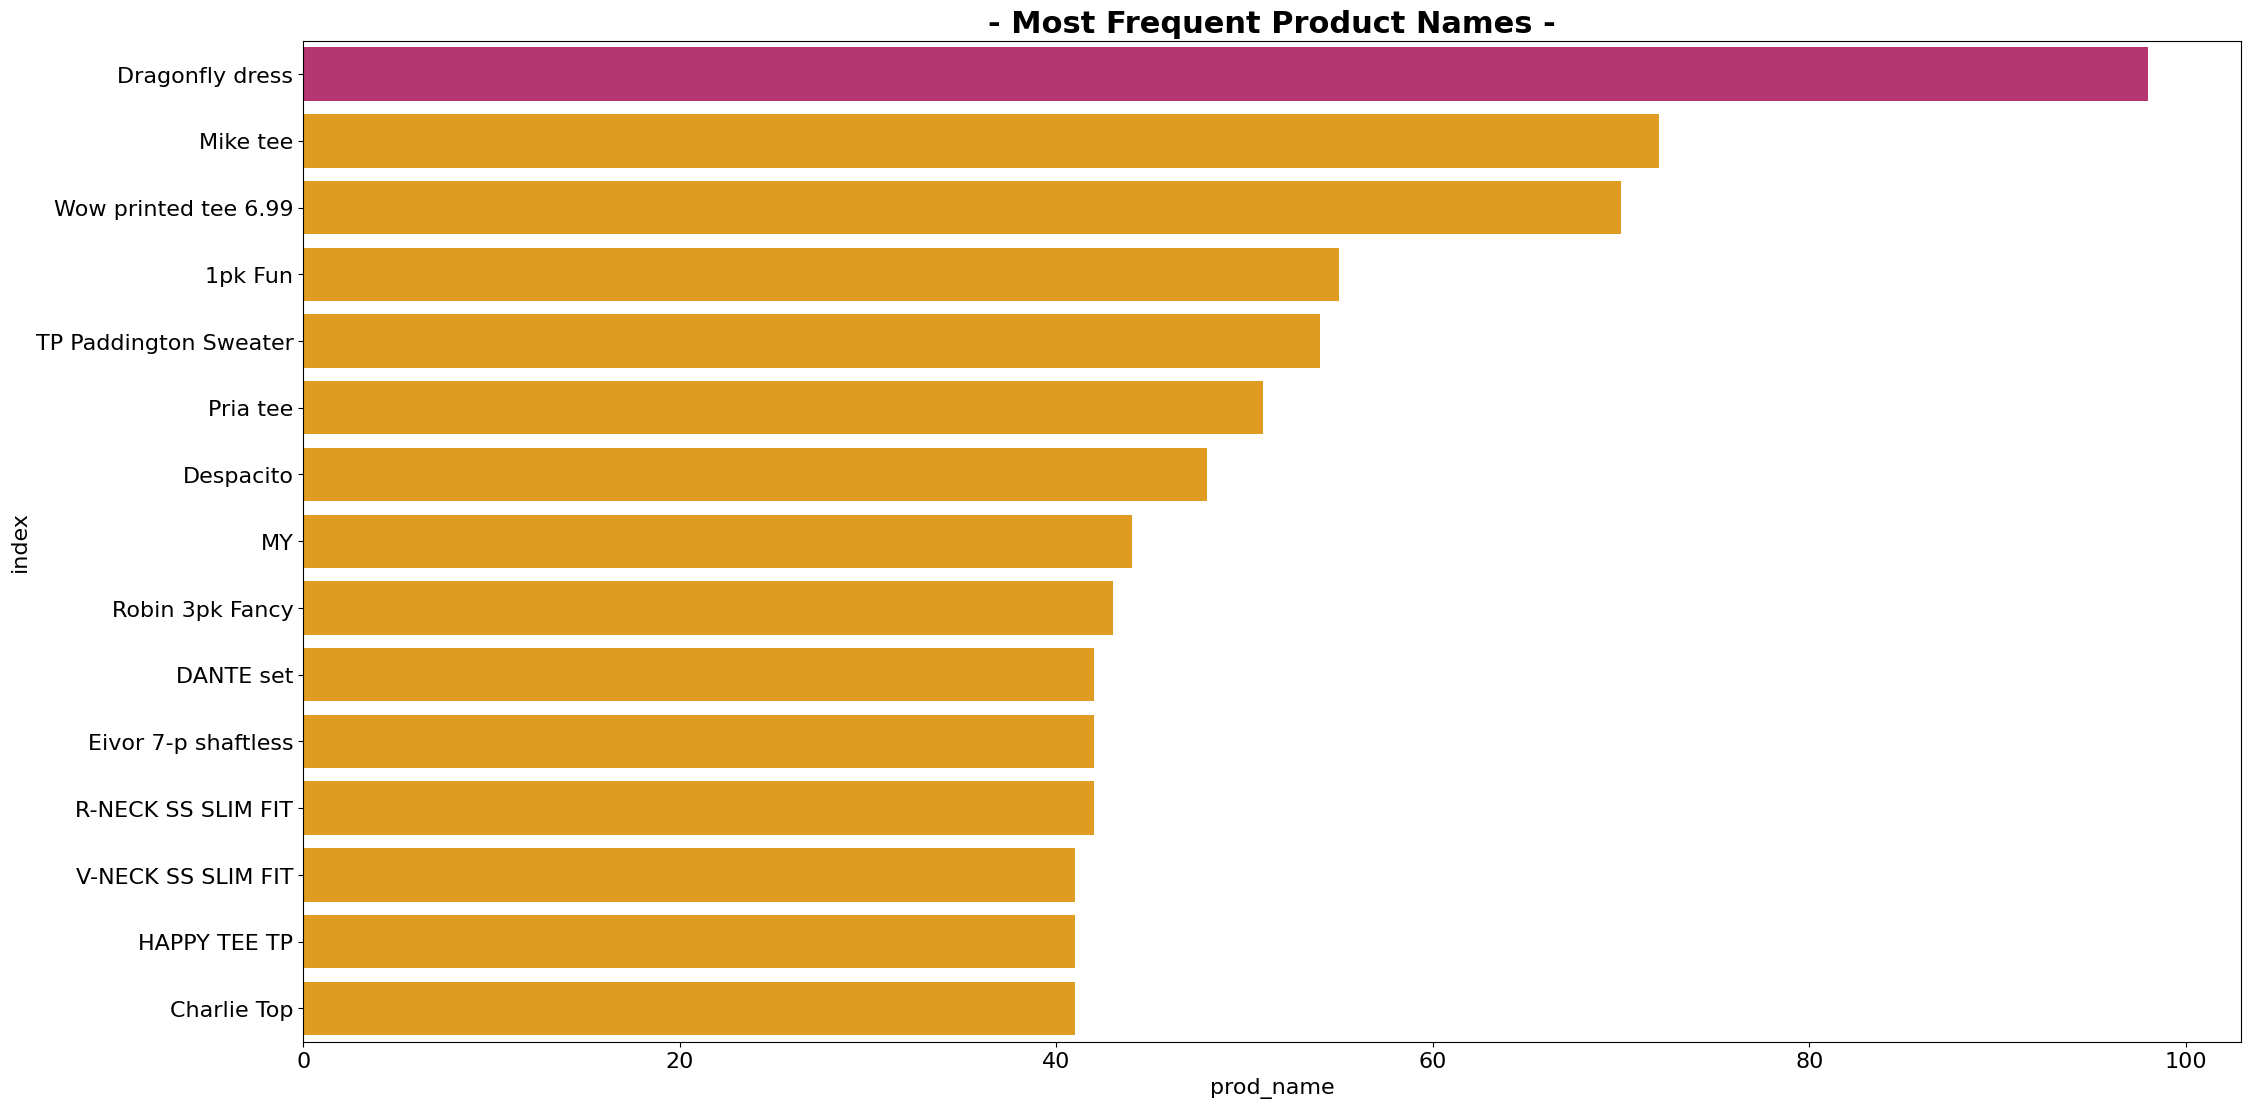

In [19]:
print(clr.S+"Total Number of unique Product Names:"+clr.E, articles["prod_name"].nunique())

# Data
prod_name = articles["prod_name"].value_counts().reset_index().head(15)
total_prod_names = articles["prod_name"].nunique()
clrs = ["#CB2170" if x==max(prod_name["prod_name"]) else '#FFA500' for x in prod_name["prod_name"]]

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Names -', size=22, weight="bold")
sns.barplot(data=prod_name, x="prod_name", y="index", ax=ax,
            palette=clrs)
plt.show()

**<span style="color:#023e8a;">Now, pay attention to index group-index structure. Ladieswear and Children/Baby have subgroups.</span>**

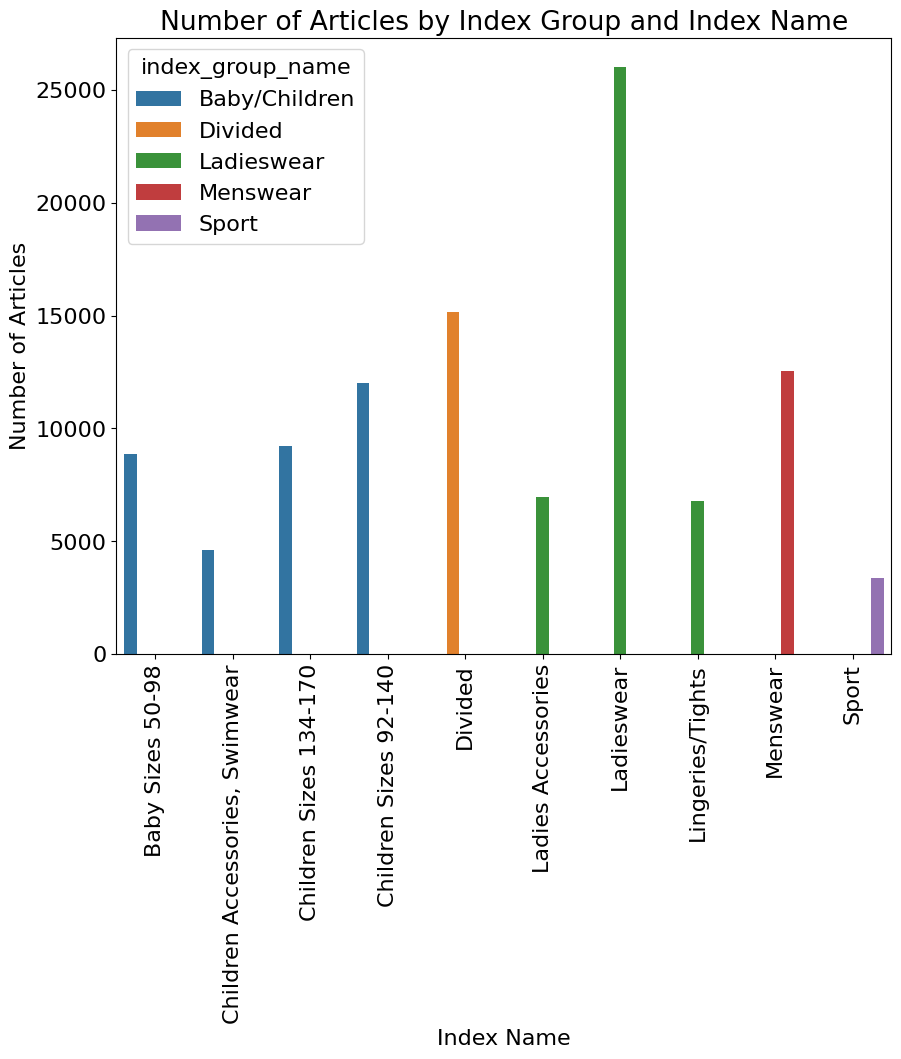

In [20]:
# articles.groupby(['index_group_name', 'index_name']).count()['article_id# create a DataFrame from the groupby object
temp_group = articles.groupby(['index_group_name', 'index_name']).count()['article_id'].reset_index()

# create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='index_name', y='article_id', hue='index_group_name', data=temp_group)
plt.title('Number of Articles by Index Group and Index Name')
plt.xlabel('Index Name')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.show()

**<span style="color:#023e8a;"> And look at the product group-product structure. Accessories are really various, the most numerious: bags, earrings and hats. However, trousers prevail.</span>**

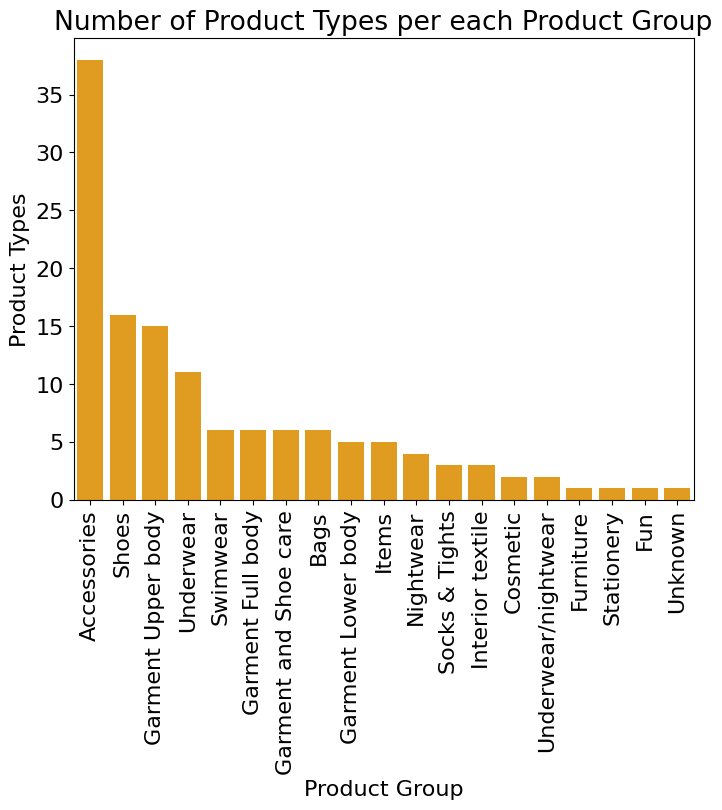

In [21]:
temp = articles.groupby(["product_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({'Product Group': temp.index,
                   'Product Types': temp.values
                  })
df = df.sort_values(['Product Types'], ascending=False)
plt.figure(figsize = (8,6))
plt.title('Number of Product Types per each Product Group')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Product Group', y="Product Types", data=df, color='orange')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [22]:
# create a list of dictionaries, where each dictionary contains the column name and its number of unique values
unique_values = []
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articles[col].nunique()
        unique_values.append({'Column Name': col, 'Number of Unique Values': un_n})

# create a pandas DataFrame from the list of dictionaries
df_unique_values = pd.DataFrame(unique_values)
# display the DataFrame
display(df_unique_values)

,Column Name,Number of Unique Values
0,prod_name,45875
1,product_type_name,131
2,product_group_name,19
3,graphical_appearance_name,30
4,colour_group_name,50
5,perceived_colour_value_name,8
6,perceived_colour_master_name,20
7,department_name,250
8,index_name,10
9,index_group_name,5



**<span style="color:#023e8a;"> And look at the product type structure. Trousers are the most sold product type followed by dress and sweater.</span>**

In [24]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Total Number of unique Product Types: 131


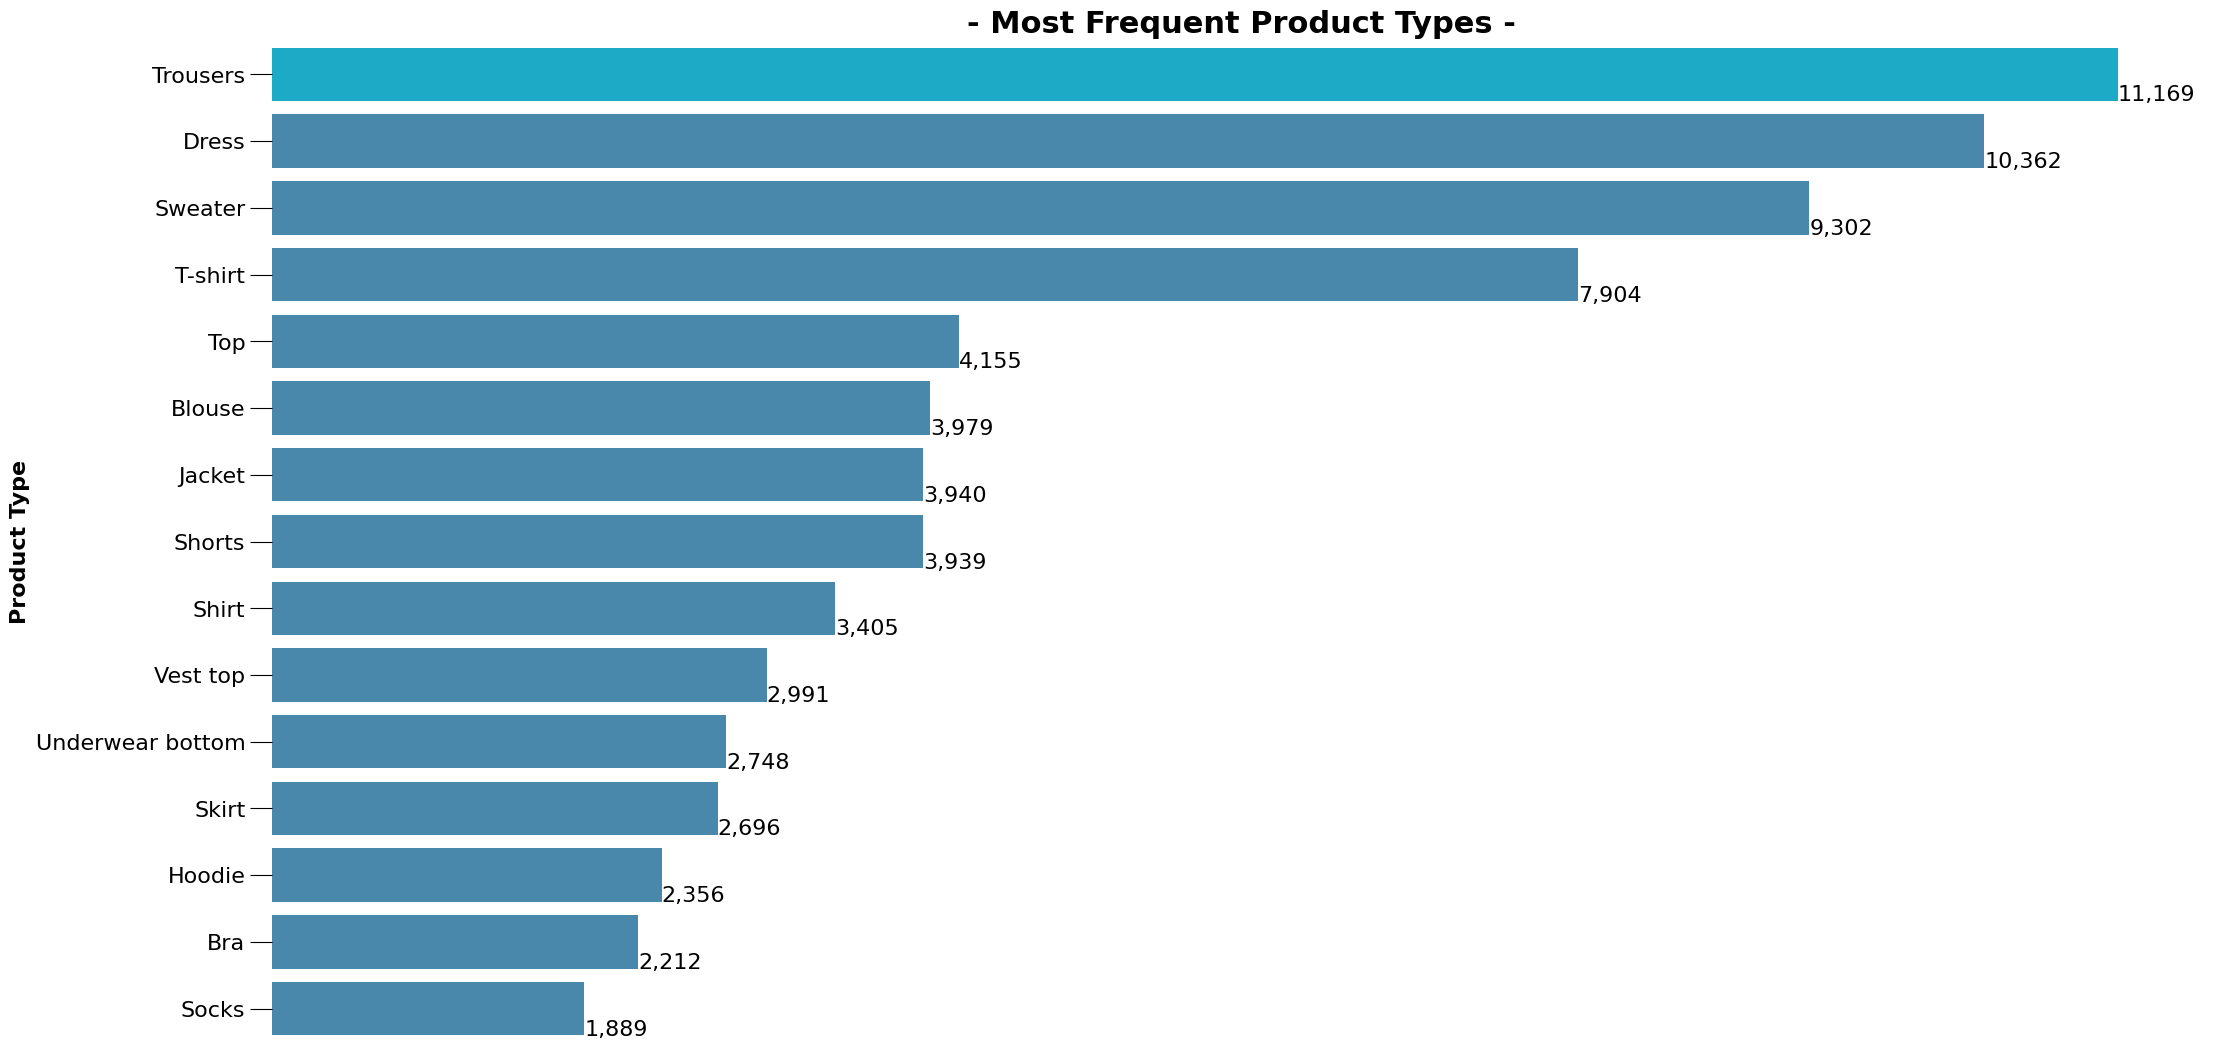

In [25]:
print(clr.S+"Total Number of unique Product Types:"+clr.E, articles["product_type_name"].nunique())

# Data
prod_type = articles["product_type_name"].value_counts().reset_index().head(15)
total_prod_types = articles["product_type_name"].nunique()
clrs = ["#00BDE3" if x==max(prod_type["product_type_name"]) else '#398BBB' for x in prod_type["product_type_name"]]


# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Types -', size=22, weight="bold")

sns.barplot(data=prod_type, x="product_type_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Type", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

**<span style="color:#023e8a;"> We can again see the upper garment are very popular.</span>**

Total Number of unique Product Group: 19


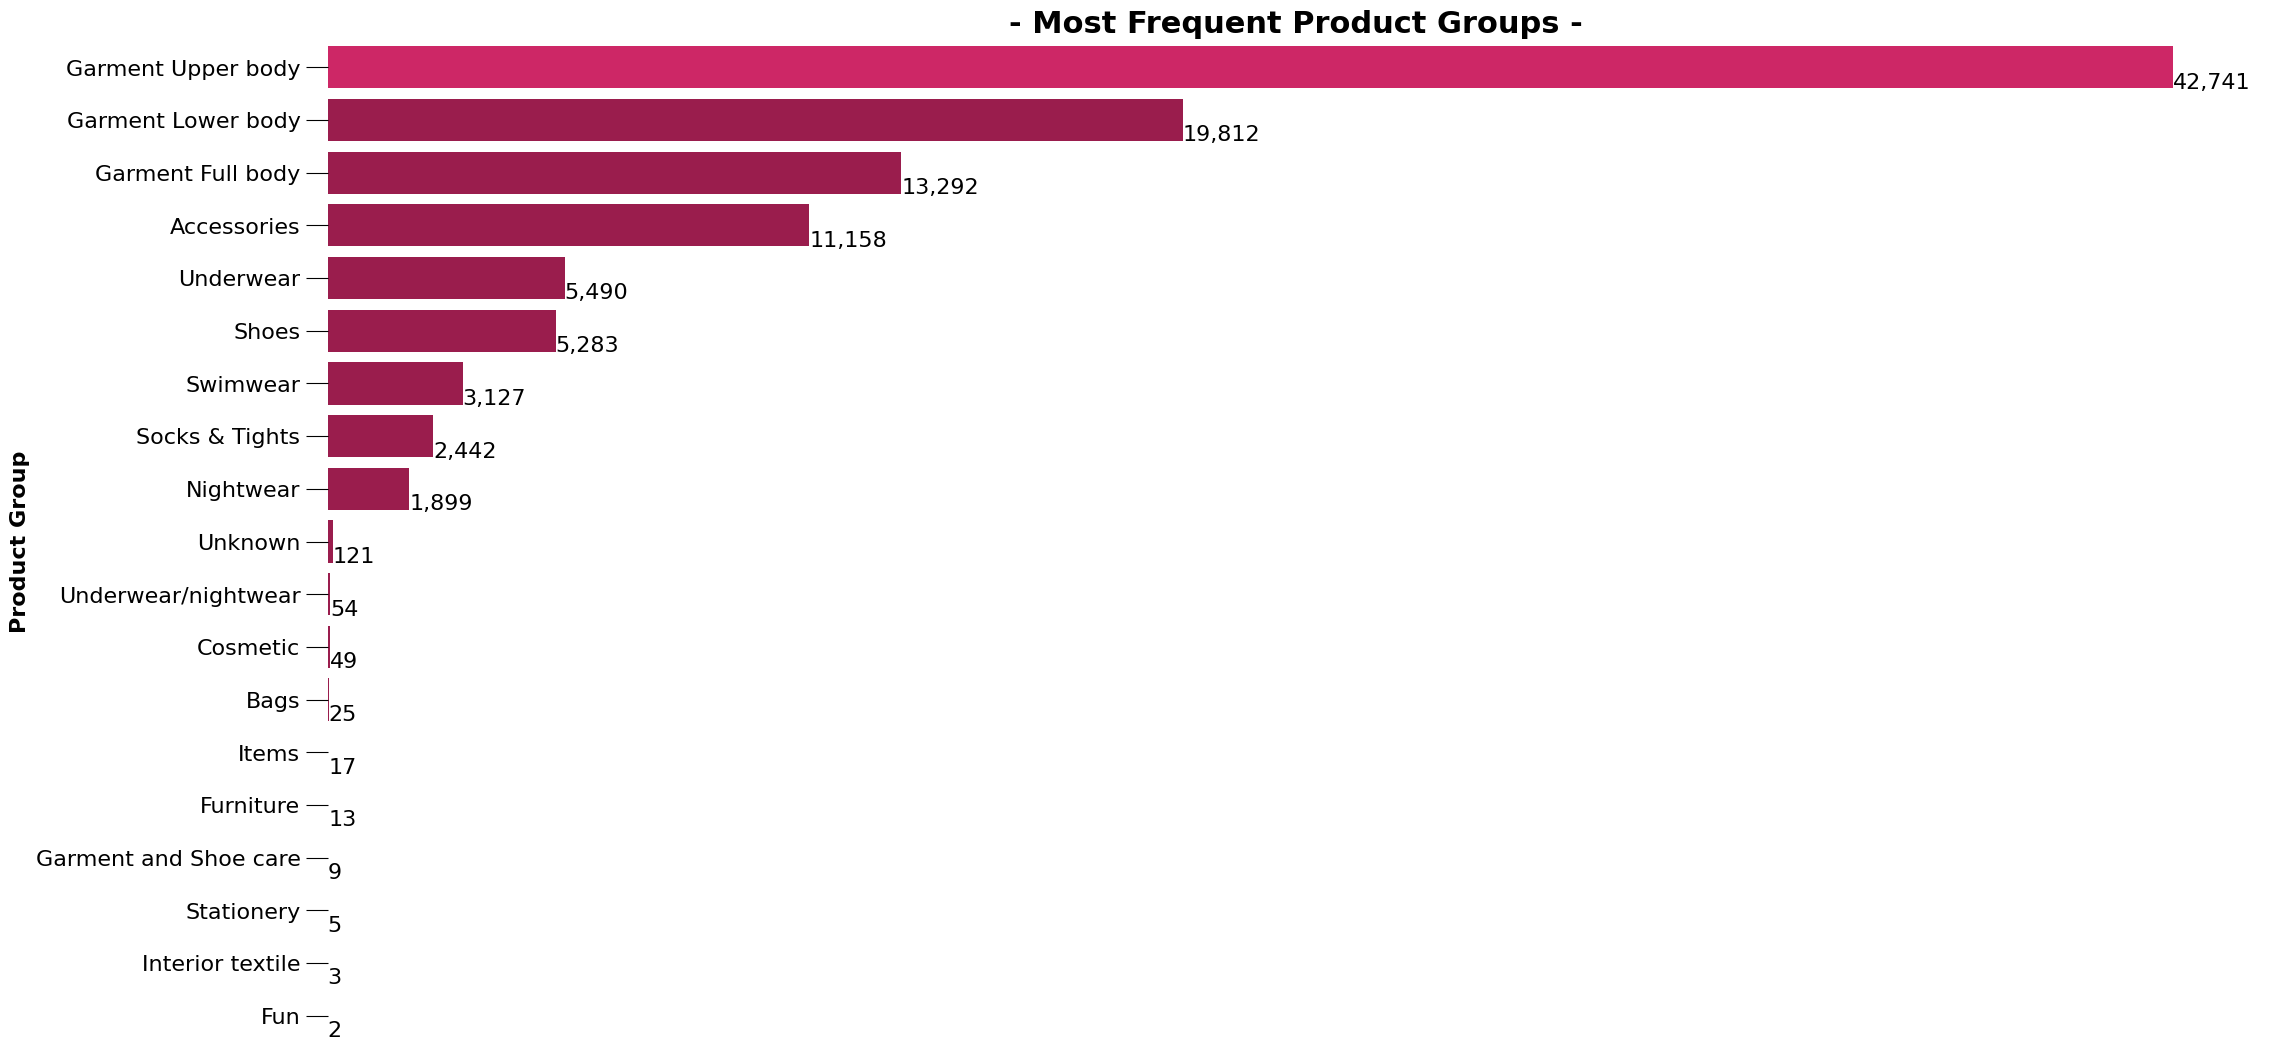

In [26]:
print(clr.S+"Total Number of unique Product Group:"+clr.E, articles["product_group_name"].nunique())

# Data
prod_group = articles["product_group_name"].value_counts().reset_index()
total_prod_groups = articles["product_group_name"].nunique()
clrs = ["#E90B60" if x==max(prod_group["product_group_name"]) else '#AF0848' for x in prod_group["product_group_name"]]

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Groups -', size=22, weight="bold")

sns.barplot(data=prod_group, x="product_group_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Group", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

Types = articles.product_group_name.unique()
count = articles.product_group_name.value_counts()
fig = px.pie(articles, values=count, names=Types, title="Product Group by population", color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.show()

In [27]:
def change_color(x):
    '''Change color name.'''
    if ("light" in x.lower().strip()) or \
        ("dark" in x.lower().strip()) or \
        ("greyish" in x.lower().strip()) or \
        ("yellowish" in x.lower().strip()) or \
        ("greenish" in x.lower().strip()) or \
        ("off" in x.lower().strip()) or \
        ("other" in x.lower().strip()):
        x = x.split(" ")[-1]

    return x

articles["colour_group_name"] = articles["colour_group_name"].apply(lambda x: change_color(x))

Total Number of unique Product Appearances: 30
Total Number of unique Product Colors (after preprocess): 20


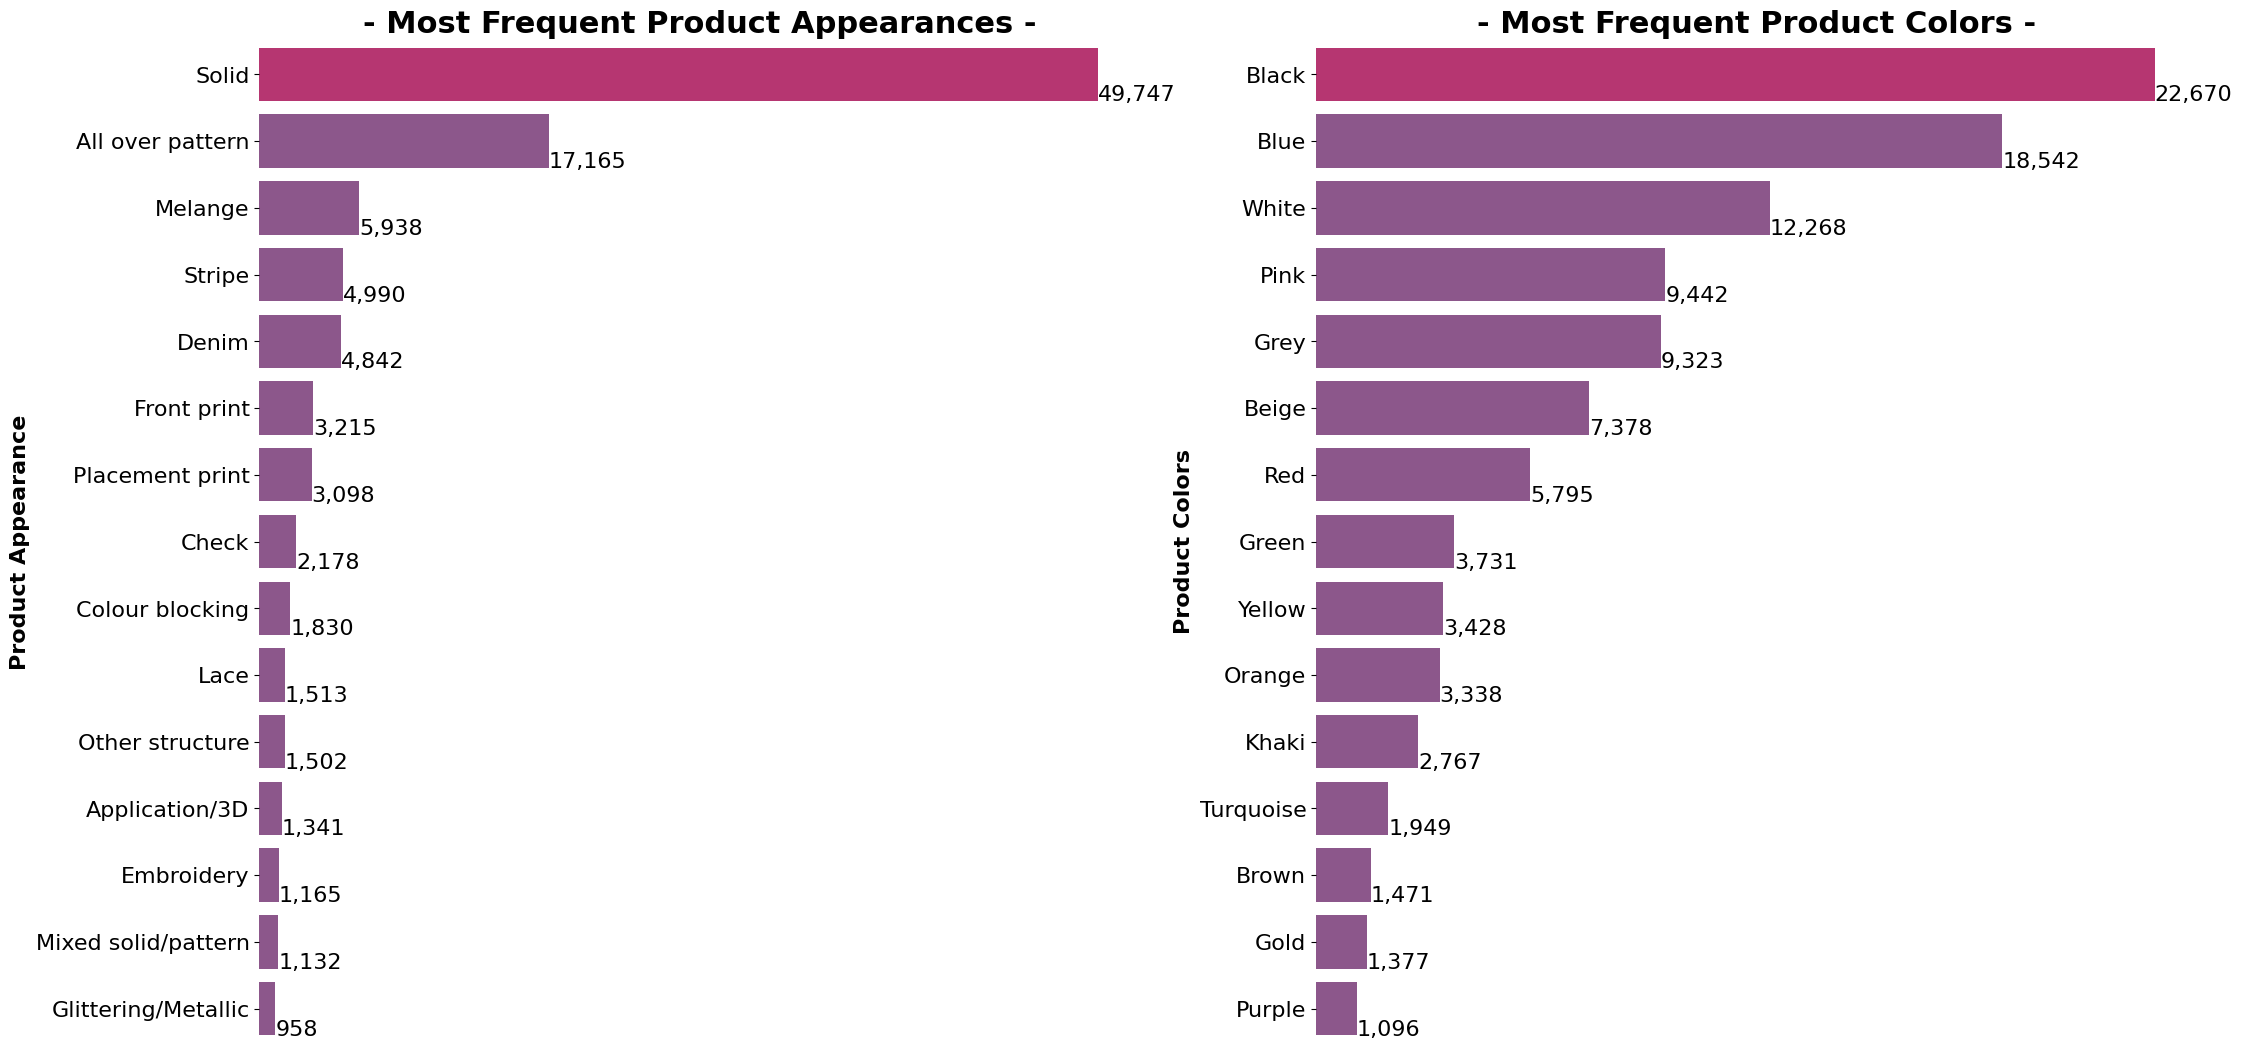

In [28]:
# Appearance and color
print(clr.S+"Total Number of unique Product Appearances:"+clr.E, articles["graphical_appearance_name"].nunique())
print(clr.S+"Total Number of unique Product Colors (after preprocess):"+clr.E, articles["colour_group_name"].nunique())

# --- Data 1 ---
prod_appearance = articles["graphical_appearance_name"].value_counts().reset_index().head(15)
total_prod_appearances = articles["graphical_appearance_name"].nunique()
clrs1 = ["#AF0848" if x==max(prod_appearance["graphical_appearance_name"]) else '#E90B60' for x in prod_appearance["graphical_appearance_name"]]

# --- Data 2 ---
prod_color = articles["colour_group_name"].value_counts().reset_index().head(15)
total_prod_color = articles["colour_group_name"].nunique()
clrs2 = ["#CB2170" if x==max(prod_color["colour_group_name"]) else '#954E93' for x in prod_color["colour_group_name"]]

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 13))

ax1.set_title('- Most Frequent Product Appearances -', size=22, weight="bold")
sns.barplot(data=prod_appearance, x="graphical_appearance_name", y="index", ax=ax1,
            palette=clrs2)
x0,x1 = ax1.get_xlim()
y0,y1 = ax1.get_ylim()

show_values_on_bars(axs=ax1, h_v="h", space=0.4)

ax1.set_ylabel("Product Appearance", size = 16, weight="bold")
ax1.set_xlabel("")
ax1.set_xticks([])

ax2.set_title('- Most Frequent Product Colors -', size=22, weight="bold")
sns.barplot(data=prod_color, x="colour_group_name", y="index", ax=ax2,
            palette=clrs2)
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()

show_values_on_bars(axs=ax2, h_v="h", space=0.4)
ax2.set_ylabel("Product Colors", size = 16, weight="bold")
ax2.set_xlabel("")
ax2.set_xticks([])

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

---

🛍️ **Important Notes**:
* In order for the wordcloud to take the shape of the image you should input a `.jpg` image with **white** background (not black and not transparent - because the function will interpret the transparent background as black).
* More custom fonts like I used below can be found here: https://www.dafont.com/

In [29]:
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    '''Creates a custom function for the color of the wordcloud.'''

    h = 270 # 0 - 360 <- the color hue
    s = 40 # 0-100 <- the color saturation
    l = random_state.randint(30, 70) # 0 - 100 <- gradient

    return "hsl({}, {}%, {}%)".format(h, s, l)

Total Number of unique Article Descriptions: 43405 



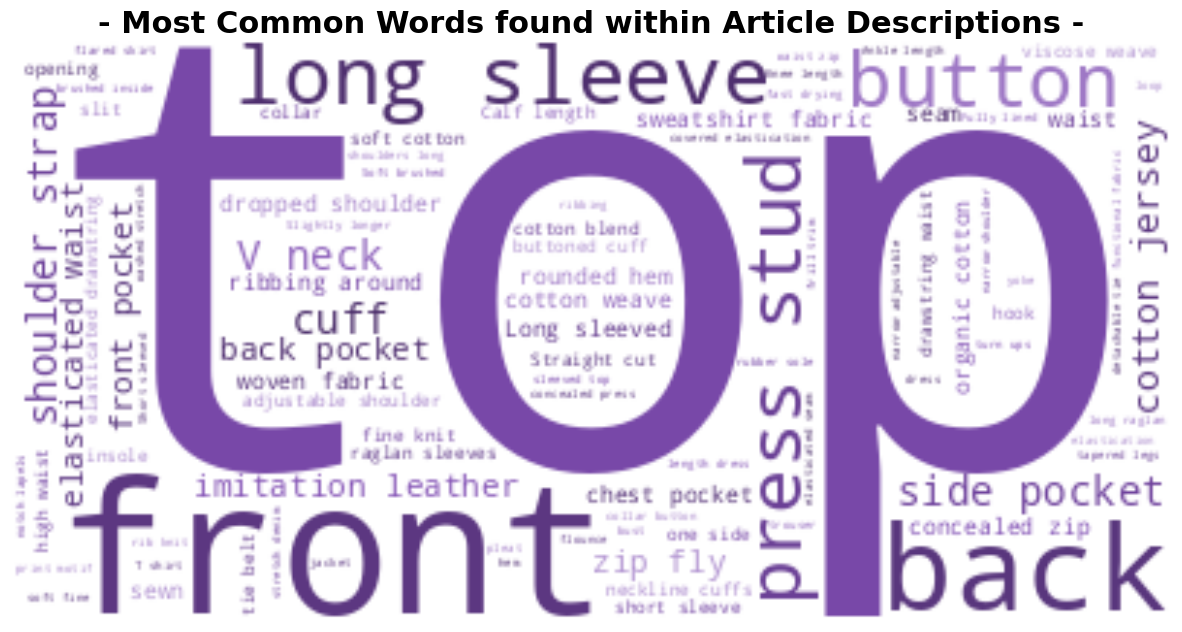

In [30]:
print(clr.S+"Total Number of unique Article Descriptions:"+clr.E, articles["detail_desc"].nunique(), "\n")

# Get descriptions and convert them to a string
text = articles["detail_desc"].unique()
text = " ".join(text)

# Get the mask - the form of the wordcloud
# mask = np.array(Image.open('../input/hm-fashion-recommender-dataset/pics/mask.jpg'))

# Create wordcloud object
wc = WordCloud(background_color="white", max_words=2000,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42,
               color_func=similar_color_func)
wc.generate(text)

# Plot
fig = plt.figure(figsize=(15, 15))
plt.title("- Most Common Words found within Article Descriptions -",
           size=22, weight="bold")
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## **<span id="Customers" style="color:#023e8a;">3. Customers</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

**<span style="color:#023e8a;"> Customers data description: </span>**

> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `FN` **<span style="color:#023e8a;">: 1 or missed </span>**  
> `Active` **<span style="color:#023e8a;">: 1 or missed</span>**  
> `club_member_status` **<span style="color:#023e8a;">: Status in club</span>**  
> `fashion_news_frequency` **<span style="color:#023e8a;">: How often H&M may send news to customer</span>**  
> `age` **<span style="color:#023e8a;">: The current age</span>**  
> `postal_code` **<span style="color:#023e8a;">: Postal code of customer</span>**  

🛍️ **Important Notes**:
* In this dataset we have quite a few missing values:
    * for columns `FN` and `Active` I replaced all missing values with 0
    * for `club_member_status` and `fashion_news_frequency` I have set all missing values with `UNKNOWN`
    * for `age` I have imputed all missing values with the median age (which is 36)
* I have created an `age_interval` as well that splits all ages in decades

In [31]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

In [32]:
print(clr.S+"Missing values within customers dataset:"+clr.E)
print(customers.isna().sum())

Missing values within customers dataset:
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64


In [33]:
# Fill FN and Active - the only available value is "1"
customers["FN"].fillna(0, inplace=True)
customers["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customers["club_member_status"].fillna("UNKNOWN", inplace=True)

customers["fashion_news_frequency"] = customers["fashion_news_frequency"].replace({"None":"NONE"})
customers["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customers["age"].fillna(customers["age"].median(), inplace=True)
# customers["age_interval"] = customers["age"].apply(lambda x: create_age_interval(x))

In [34]:
pd.options.display.max_rows = 50
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


**<span style="color:#023e8a;"> There are no duplicates in </span>** `customers`

In [35]:
customers.shape[0] - customers['customer_id'].nunique()

0

**<span style="color:#023e8a;"> Here we have abnormal number of customers by one postal code. One has 120303, it might be encoded nan adress or smth like a huge distribution center, or pickup.</span>**

In [36]:
data_postal = customers.groupby('postal_code', as_index=False).count().sort_values('customer_id', ascending=False)
data_postal.head()

,postal_code,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
61034,2c29ae653a9282cce4151bd87643c907644e09541abc28...,120303,120303,120303,120303,120303,120303
281937,cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac...,261,261,261,261,261,261
156090,714976379549eb90aae4a71bca6c7402cc646ae7c40f6c...,159,159,159,159,159,159
171208,7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5...,157,157,157,157,157,157
126228,5b7eb31eabebd3277de632b82267286d847fd5d44287ee...,156,156,156,156,156,156


**<span style="color:#023e8a;"> Ages, club_member_status are different, like customer_ids.</span>**

In [37]:
customers[customers['postal_code']=='2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c'].head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,0.0,0.0,UNKNOWN,UNKNOWN,32.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,0.0,0.0,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,0.0,0.0,ACTIVE,NONE,20.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
11,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.0,0.0,ACTIVE,NONE,31.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
14,0000ae1bbb25e04bdc7e35f718e852adfb3fbb72ef38b3...,1.0,1.0,ACTIVE,Regularly,29.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...


**<span style="color:#023e8a;"> The most common age is about 21-23</span>**

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers, x='age', bins=50, color='orange')
ax.set_xlabel('Distribution of the customers age')
plt.show()

**<span style="color:#023e8a;"> Status in H&M club. Almost every customer has an active club status, some of them begin to activate it (pre-create). A tiny part of customers abandoned the club.</span>**

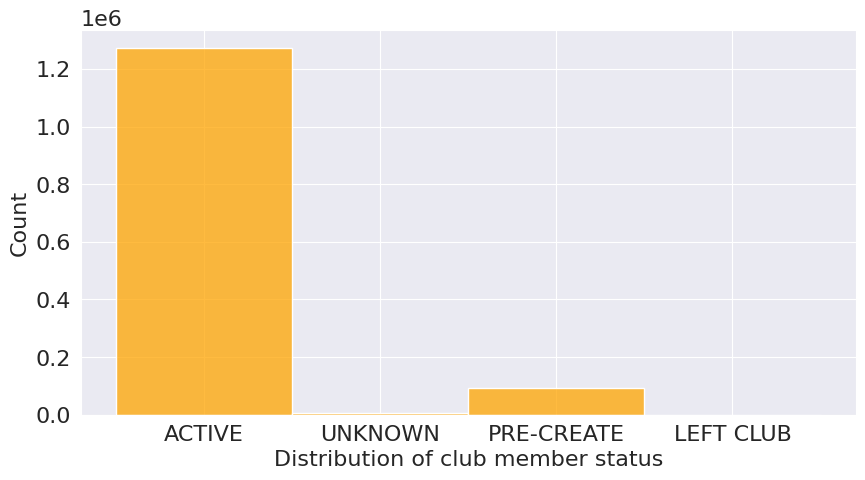

In [39]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customers, x='club_member_status', color='orange')
ax.set_xlabel('Distribution of club member status')
plt.show()

**<span style="color:#023e8a;"> Here we have three types for NO DATA. Let's unite these values.</span>**

In [40]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', 'UNKNOWN', 'Monthly'], dtype=object)

In [41]:
customers.loc[~customers['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = 'None'
customers['fashion_news_frequency'].unique()

array(['None', 'Regularly', 'Monthly'], dtype=object)

In [42]:
pie_data = customers[['customer_id', 'fashion_news_frequency']].groupby('fashion_news_frequency').count()

**<span style="color:#023e8a;"> Customers prefer not to get any messages about the current news.</span>**

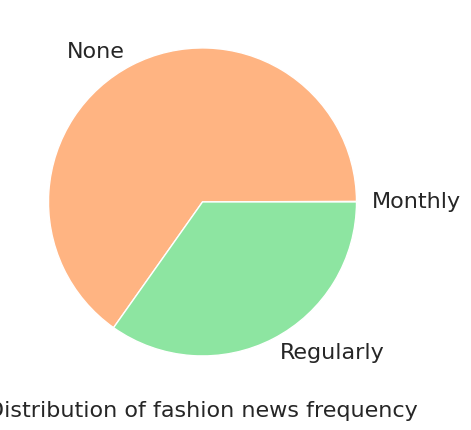

In [43]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
# ax = sns.histplot(data=customers, x='fashion_news_frequency', color='orange')
# ax = sns.pie(data=customers, x='fashion_news_frequency', color='orange')
colors = sns.color_palette('pastel')
ax.pie(pie_data.customer_id, labels=pie_data.index, colors = colors)
ax.set_facecolor('lightgrey')
ax.set_xlabel('Distribution of fashion news frequency')
plt.show()

## **<span id="Transactions" style="color:#023e8a;">4. Transactions</span>**

[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)

**<span style="color:#023e8a;"> Transactions data description: </span>**

> `t_dat` **<span style="color:#023e8a;">: A unique identifier of every customer</span>**  
> `customer_id` **<span style="color:#023e8a;">: A unique identifier of every customer </span>**  **<span style="color:#FF0000;">(in </span>** `customers` **<span style="color:#FF0000;"> table)</span>**  
> `article_id` **<span style="color:#023e8a;">: A unique identifier of every article</span>**  **<span style="color:#FF0000;">(in </span>** `articles` **<span style="color:#FF0000;"> table)</span>**  
> `price` **<span style="color:#023e8a;">: Price of purchase</span>**  
> `sales_channel_id` **<span style="color:#023e8a;">: 1 or 2</span>**  

🛍️ **Important Notes**:
* Denims, Trousers and Undergarments are sold the most.
* The **prices are altered**, with the highest one being 0.59 and the lowest being 0.0000169.
* The most expensive items are leather garments.
* The average order has around 23 units and costs ~0.649.
* The units/order is directly correlated with the price/order: as the units increase, the price within the order increases too.

In [44]:
print(clr.S+"Missing values within transactions dataset:"+clr.E)
print(transactions.isna().sum())

Missing values within transactions dataset:
customer_id         0
article_id          0
price               0
sales_channel_id    0
year                0
month               0
day                 0
dtype: int64


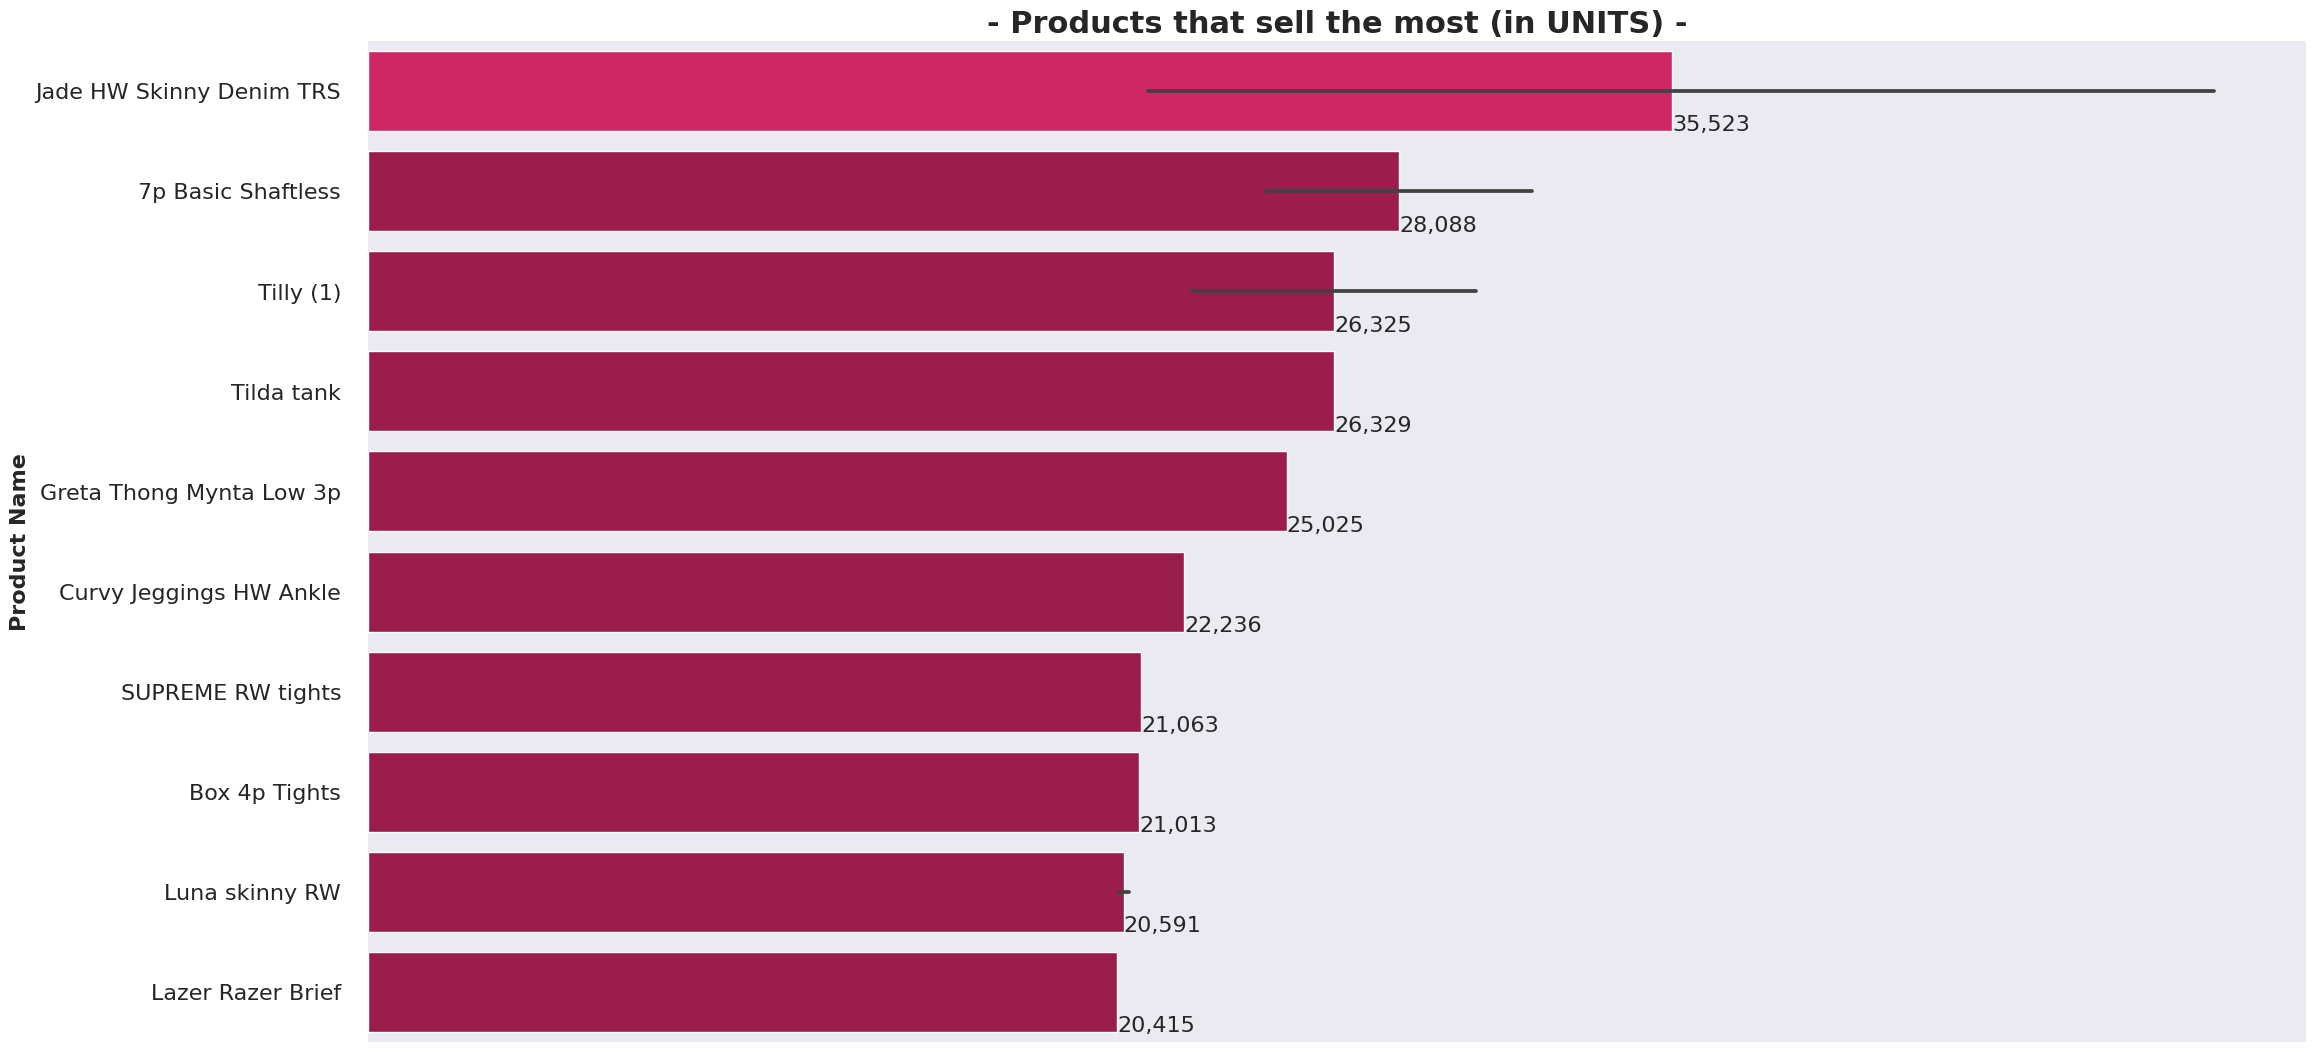

In [45]:
# Get data
top_sold_products = transactions["article_id"].value_counts().reset_index().head(15)
top_sold_products.columns = ["article_id", "count"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "count", "prod_name"]]

clrs = ["#E90B60" if x==max(top_sold_products["count"]) else '#AF0848' for x in top_sold_products["count"]]
# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Products that sell the most (in UNITS) -', size=22, weight="bold")

sns.barplot(data=top_sold_products, x="count", y="prod_name", ax=ax,
            palette=clrs)

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Name", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

sns.despine(left=True, bottom=True)
plt.show();

In [46]:
print(clr.S+"Maximum Price is:"+clr.E, transactions["price"].max(), "\n" +
      clr.S+"Minimum Price is:"+clr.E, transactions["price"].min(), "\n" +
      clr.S+"Average Price is:"+clr.E, transactions["price"].mean())

# Get data
top_sold_products = transactions.groupby("article_id")["price"].max().reset_index()\
                                        .sort_values("price", ascending=False).head(15)
top_sold_products.columns = ["article_id", "price"]
top_sold_products = pd.merge(top_sold_products, articles, on="article_id")[["article_id", "price", "prod_name"]]
print(clr.S + "Most Expensive products:" + clr.E)
display(top_sold_products)

Maximum Price is: 0.59152544 
Minimum Price is: 1.6949152e-05 
Average Price is: 0.027829282
Most Expensive products:


,article_id,price,prod_name
0,697511001,0.591525,PE LINDA LEATHER COAT
1,839478001,0.506780,PQ SUSAN LEATHER TUNIC
2,653551001,0.506780,Benji leather jacket
3,797432001,0.506780,CEMENT leather jacket
4,810872001,0.506780,PQ AGDA LEATHER DRESS
5,613539001,0.506780,CE Ivy lace dress
6,916300001,0.506780,PQ OLGA LEATHER DRESS
7,713219001,0.506780,LEMON Shearling Jacket 1
8,916300002,0.506780,PQ OLGA LEATHER DRESS
9,805760001,0.506780,LEMON shearling jacket


=== UNITS/ORDER ===
Maximum Units/Order is: 1895 
Minimum Units/Order is: 1 
Average Units/Order is: 23.334630667241193 

=== SPENDING/ORDER ===
Maximum Spending/Order is: 57.676407 
Minimum Spending/Order is: 0.00076271186 
Average Spending/Order is: 0.64938575


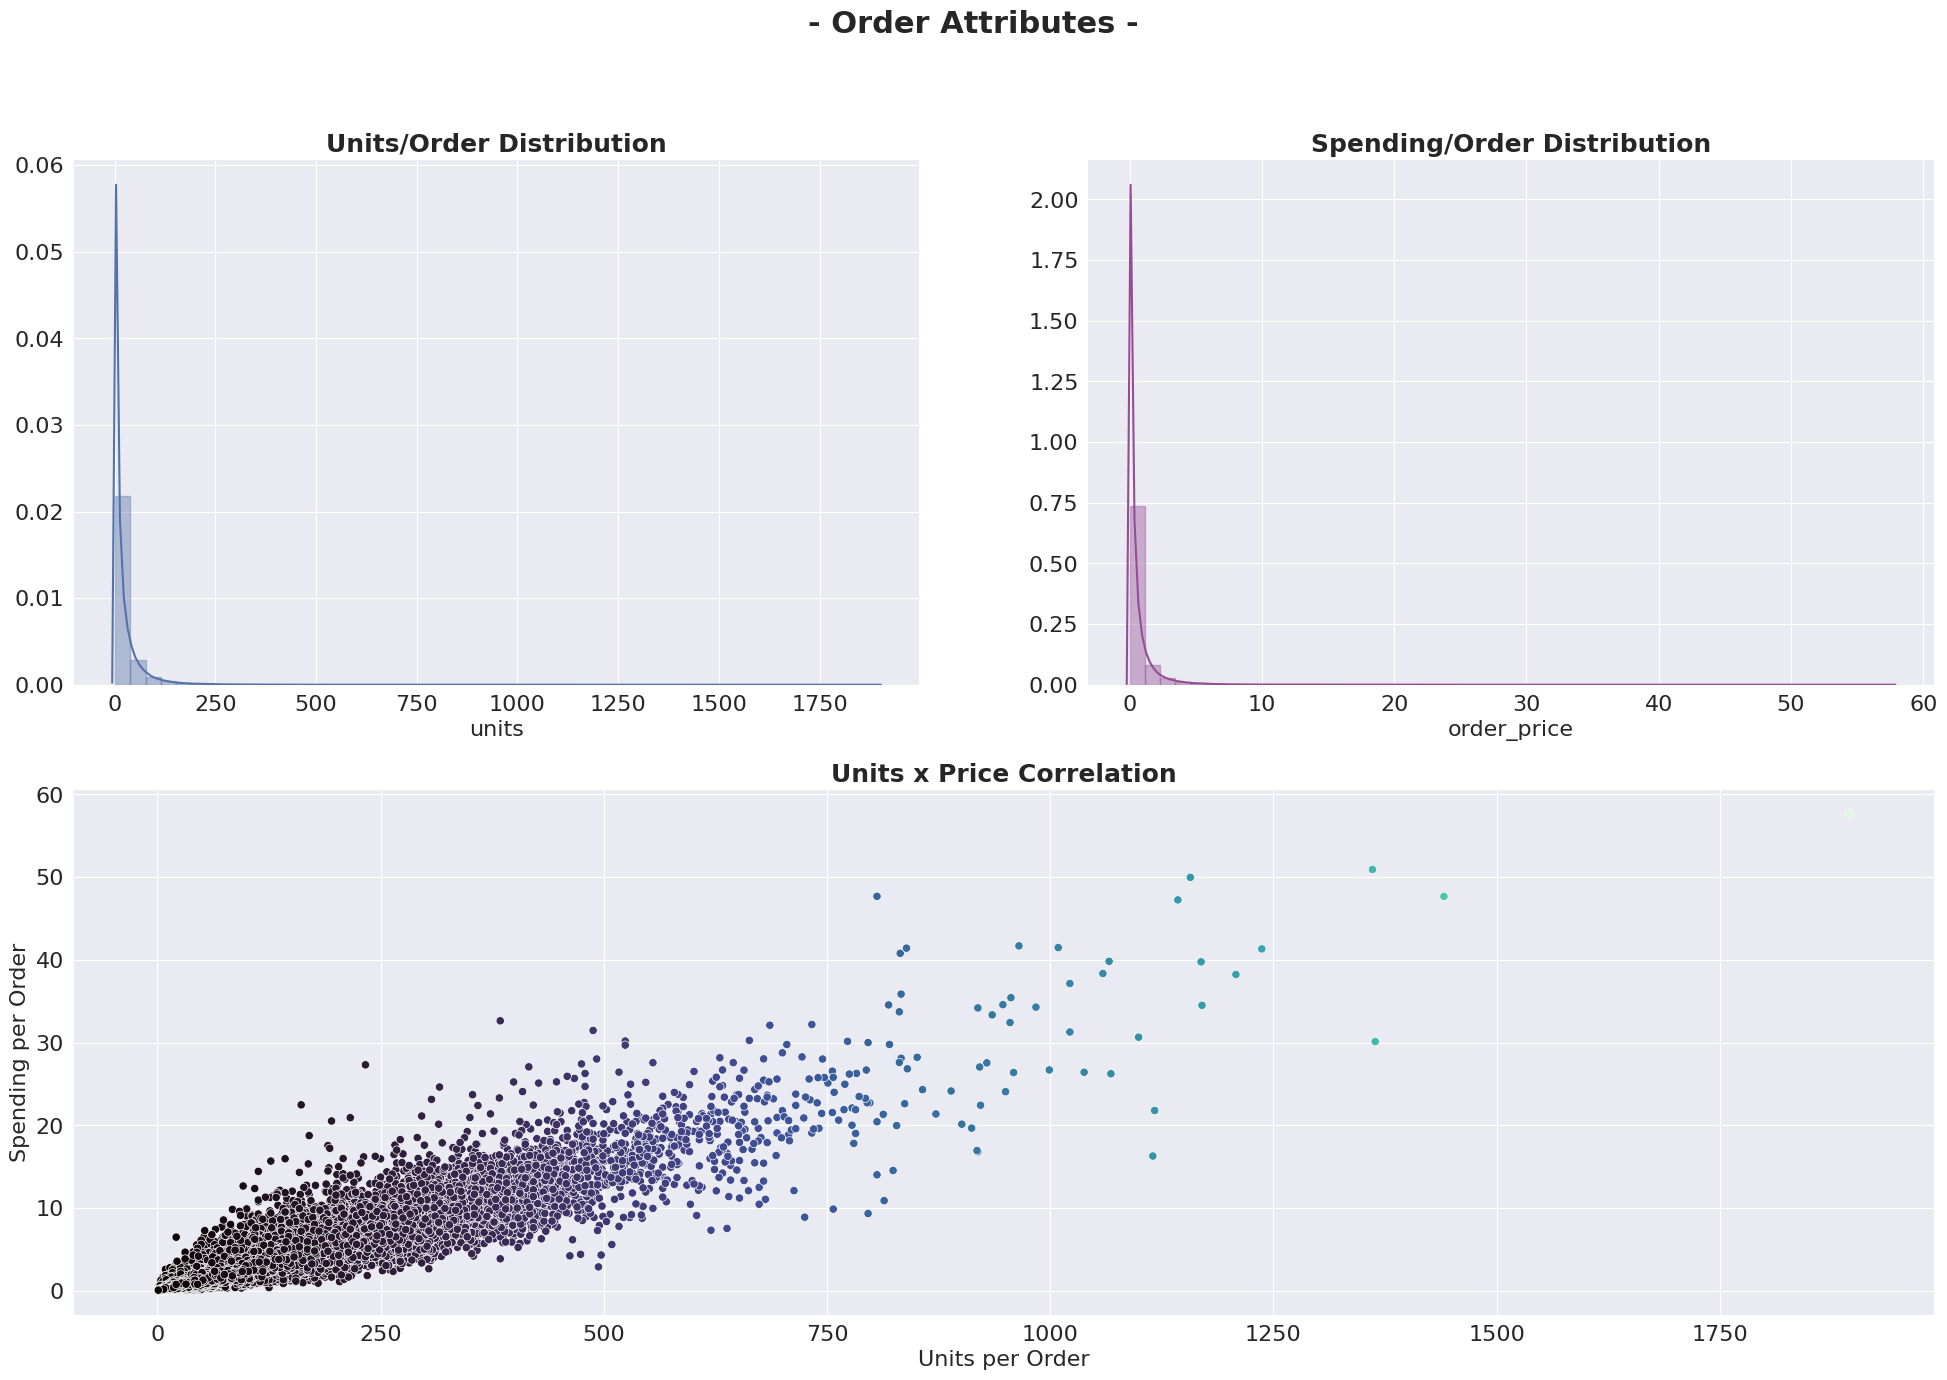

In [47]:
# Data
basket = transactions.groupby("customer_id").agg({'article_id':'count',
                                                  'price': 'sum'}).reset_index()
basket.columns = ["customer_id", "units", "order_price"]

print(clr.S+"=== UNITS/ORDER ==="+clr.E)
print(clr.S+"Maximum Units/Order is:"+clr.E, basket["units"].max(), "\n" +
      clr.S+"Minimum Units/Order is:"+clr.E, basket["units"].min(), "\n" +
      clr.S+"Average Units/Order is:"+clr.E, basket["units"].mean(), "\n")

print(clr.S+"=== SPENDING/ORDER ==="+clr.E)
print(clr.S+"Maximum Spending/Order is:"+clr.E, basket["order_price"].max(), "\n" +
      clr.S+"Minimum Spending/Order is:"+clr.E, basket["order_price"].min(), "\n" +
      clr.S+"Average Spending/Order is:"+clr.E, basket["order_price"].mean())

# Plot
plt.figure(figsize=(24, 15))
plt.suptitle('- Order Attributes -', size=22, weight="bold")

ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.distplot(basket["units"], color=my_colors[-3], ax=ax1,
             hist_kws=dict(edgecolor=my_colors[-3]))
ax1.set_title("Units/Order Distribution", size=18, weight="bold")
ax1.set_ylabel("")

sns.distplot(basket["order_price"], color=my_colors[-5], ax=ax2,
             hist_kws=dict(edgecolor=my_colors[-5]))
ax2.set_title("Spending/Order Distribution", size=18, weight="bold")
ax2.set_ylabel("")

sns.scatterplot(data=basket, x="units", y="order_price", hue="units", palette="mako",
                legend=None, ax=ax3)
ax3.set_title("Units x Price Correlation", size=18, weight="bold")
ax3.set_ylabel("Spending per Order")
ax3.set_xlabel("Units per Order")

sns.despine(left=True, bottom=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None);

## **<span id="Recommendation" style="color:#023e8a;">5. Recommender System</span>**


[**<span style="color:#FEF1FE;background-color:#023e8a;border-radius: 5px;padding: 2px">Go to Table of Content</span>**](#Content)


**What is a Recommender System**?

A recommender system is not more or less than an algorithm that tries to predict the preference on an object or concept based on somebody's preferences for other objects or concepts.

This can apply to **anything**: movies, songs, books, amazon orders, clothing or just Google Engine searches.

<center><img src="https://i.imgur.com/m8T6MhL.png" width=500></center>

<!-- > 🛍 **Turicreate**: we will be using `turicreate` model in order to create recommendations for users based on their previous purchases. For more details about the library you can [read the documentation](https://github.com/apple/turicreate). My main inspiration was this amazing article [How to Build a Recommendation System for Purchase Data (Step-by-Step)](https://medium.datadriveninvestor.com/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6). -->

<font size="3">  I will create 5 DFs; <br>
    <br>
                 1. DF with customers and the products they bought.<br>
                 2. DF with features of products and customers who have bought it<br>
                 3. DF with the features of the products they have bought next to the customers who have bought a product<br>
                 4. The DF we will use to fill in the missing values during the creation of our model values <br>
                 5. The DF I will use in the modeling phase <br>
</font>     

We will use only 10000 transactions to train it. Also We will use all the data from the articles and customers data

In [48]:
transactions = transactions.head(10000)
transactions

,customer_id,article_id,price,sales_channel_id,year,month,day
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,18,9,20
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,18,9,20
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,18,9,20
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18,9,20
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18,9,20
...,...,...,...,...,...,...,...
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002,0.003373,2,18,9,20
9996,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,305304008,0.011847,2,18,9,20
9997,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,561617003,0.023712,2,18,9,20
9998,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,671777002,0.006763,2,18,9,20


<a id='transactionsCustomerArticlesDF' style="color:black" /></a>
### 1. DF with customers and the products they bought

In [49]:
transactions['customer_id'].unique().size

2954

<font size="3">I am creating a table where every customer who buys is once. I will combine it with the products of my customer that I grouped into this table.</font>

In [50]:
df_groupedCustomerTransactions = transactions.groupby(["customer_id"],as_index=False)
df_TRS_TR_OneCus = transactions.drop_duplicates(subset=['customer_id'])

In [51]:
try:
    df_TRS_TR_OneCus.insert(len(df_TRS_TR_OneCus.columns), 'articles', [None] * len(df_TRS_TR_OneCus))
except:
    print("Already created")

In [52]:
def get_article_indexes(val):
    groupArticles = df_groupedCustomerTransactions.get_group(val)['article_id'].reset_index()
    groupArticles = groupArticles.drop(['index'],axis=1)
    groupArticles = groupArticles.to_numpy()
    groupArticles = np.reshape(groupArticles, groupArticles.size)

    df_TRS_TR_OneCus.loc[df_TRS_TR_OneCus['customer_id'] == val,'articles'] = ','.join(map(str, groupArticles))

In [53]:
df_TRS_TR_OneCus = df_TRS_TR_OneCus.drop(['sales_channel_id','price','day','month','year'],axis=1,errors = 'ignore')

In [54]:
df_TRS_TR_OneCus['customer_id'].apply(get_article_indexes)

0       None
2       None
7       None
12      None
14      None
        ... 
9983    None
9985    None
9988    None
9995    None
9996    None
Name: customer_id, Length: 2954, dtype: object

In [55]:
df_TRS_TR_OneCus = df_TRS_TR_OneCus.drop(['article_id'],axis=1,errors = 'ignore')

In [56]:
df_TRS_TR_OneCus

,customer_id,articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"663713001,541518023"
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,"505221004,685687003,685687004,685687001,505221001"
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,"688873012,501323011,598859003,688873020,688873011"
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,"531310002,529841001"
14,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,"501820043,501820043,674681001,671505001,671505..."
...,...,...
9983,365bfd22ce4b8aabeb84c847266a80a225b04f188629bf...,"673677002,636455008"
9985,365d866c4dcfcdf9c7abe4ccd9a0c3beb8e145db7a9524...,"622238007,622238009,622238018"
9988,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,"657165001,189616008,524939008,610274009,627554..."
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002


### 2. DF with features of products and customers who have bought it

In [57]:
customers = customers.drop(['postal_code'],axis=1,errors='ignore')

In [58]:
for col in customers:
    if(col == 'customer_id'):
        continue
    if(col == 'age_interval'):
        continue
    print(customers[col].unique())

[0. 1.]
[0. 1.]
['ACTIVE' 'UNKNOWN' 'PRE-CREATE' 'LEFT CLUB']
['None' 'Regularly' 'Monthly']
[49. 25. 24. 54. 52. 32. 20. 29. 31. 56. 75. 41. 27. 30. 48. 35. 22. 40.
 38. 45. 68. 55. 19. 60. 44. 21. 26. 28. 53. 33. 17. 23. 51. 18. 34. 57.
 47. 70. 50. 63. 58. 43. 67. 72. 42. 39. 79. 71. 59. 36. 62. 37. 46. 73.
 64. 74. 61. 85. 69. 76. 66. 65. 82. 16. 90. 80. 78. 81. 84. 77. 97. 89.
 83. 98. 88. 86. 87. 93. 91. 99. 96. 94. 92. 95.]


In [59]:
customers = pd.get_dummies(customers, columns = ["club_member_status"], prefix = ["CMS"])
customers = pd.get_dummies(customers, columns = ["fashion_news_frequency"], prefix = ["FNF"])

In [60]:
customers.columns

Index(['customer_id', 'FN', 'Active', 'age', 'CMS_ACTIVE', 'CMS_LEFT CLUB',
       'CMS_PRE-CREATE', 'CMS_UNKNOWN', 'FNF_Monthly', 'FNF_None',
       'FNF_Regularly'],
      dtype='object')

In [61]:
df_merged_transactionsCustomer = pd.merge(transactions, customers, on='customer_id', how='left')

In [62]:
df_groupedBuyingArticles = df_merged_transactionsCustomer.groupby(["article_id"],as_index=False)

In [63]:
df_groupedBuyingArticles[["price"]].aggregate("mean")

,article_id,price
0,108775015,0.008393
1,108775051,0.005068
2,110065001,0.022864
3,110065002,0.025407
4,111586001,0.012860
...,...,...
4898,725253001,0.044475
4899,727754001,0.020322
4900,728162001,0.008458
4901,728162002,0.008458


The average of the characteristics of the customers who purchased the product. I'm buying. For example, if there is 0.3 cms_active, it means that 3 out of 10 users are active.

In [64]:
# pd.set_option('display.max_rows', 50)
df_groupedBuyingArticles[["CMS_ACTIVE","CMS_UNKNOWN","CMS_LEFT CLUB","CMS_PRE-CREATE",
                    "FNF_None","FNF_Monthly","FNF_Regularly"]].mean()

,article_id,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
0,108775015,1.0,0.0,0.0,0.0,0.333333,0.0,0.666667
1,108775051,1.0,0.0,0.0,0.0,1.000000,0.0,0.000000
2,110065001,1.0,0.0,0.0,0.0,0.000000,0.0,1.000000
3,110065002,1.0,0.0,0.0,0.0,0.000000,0.0,1.000000
4,111586001,1.0,0.0,0.0,0.0,1.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...
4898,725253001,1.0,0.0,0.0,0.0,0.000000,0.0,1.000000
4899,727754001,1.0,0.0,0.0,0.0,1.000000,0.0,0.000000
4900,728162001,1.0,0.0,0.0,0.0,1.000000,0.0,0.000000
4901,728162002,1.0,0.0,0.0,0.0,1.000000,0.0,0.000000


In [65]:
df_groupedBuyingArticles[["age"]].aggregate("mean")

,article_id,age
0,108775015,32.00
1,108775051,29.00
2,110065001,20.00
3,110065002,51.00
4,111586001,40.25
...,...,...
4898,725253001,28.50
4899,727754001,26.00
4900,728162001,27.00
4901,728162002,27.00


In [66]:
df_groupedBuyingArticles[["FN"]].aggregate("mean")

,article_id,FN
0,108775015,0.666667
1,108775051,0.000000
2,110065001,1.000000
3,110065002,1.000000
4,111586001,0.000000
...,...,...
4898,725253001,1.000000
4899,727754001,0.000000
4900,728162001,0.000000
4901,728162002,0.000000


In [67]:
df_groupedBuyingArticlesValues = df_groupedBuyingArticles[["price"]].aggregate("mean")
cacheArr = df_groupedBuyingArticles[["customer_id"]].count().sort_values('customer_id', ascending=False)
cacheArr2 = df_groupedBuyingArticles[["FN"]].aggregate("mean")
cacheArr3 = df_groupedBuyingArticles[["Active"]].aggregate("mean")
cacheArr4 = df_groupedBuyingArticles[["age"]].aggregate("mean")
cacheArr5 = df_groupedBuyingArticles[["CMS_ACTIVE","CMS_UNKNOWN","CMS_LEFT CLUB","CMS_PRE-CREATE",
                    "FNF_None","FNF_Monthly","FNF_Regularly",]].mean()
df_groupedBuyingArticlesValues = pd.merge(df_groupedBuyingArticlesValues,cacheArr, how='outer')
df_groupedBuyingArticlesValues = pd.merge(df_groupedBuyingArticlesValues,cacheArr2, how='outer')
df_groupedBuyingArticlesValues = pd.merge(df_groupedBuyingArticlesValues,cacheArr3, how='outer')
df_groupedBuyingArticlesValues = pd.merge(df_groupedBuyingArticlesValues,cacheArr4, how='outer')
df_groupedBuyingArticlesValues = pd.merge(df_groupedBuyingArticlesValues,cacheArr5, how='outer').sort_values('customer_id', ascending=False)

del cacheArr, cacheArr2, cacheArr3, cacheArr4, cacheArr5
df_groupedBuyingArticlesValues

,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
4641,685687004,0.016795,98,0.428571,0.428571,40.989796,1.000000,0.000000,0.0,0.0,0.571429,0.0,0.428571
4638,685687001,0.016822,56,0.410714,0.410714,38.321429,0.964286,0.035714,0.0,0.0,0.589286,0.0,0.410714
4640,685687003,0.016912,51,0.450980,0.450980,39.862745,0.980392,0.019608,0.0,0.0,0.549020,0.0,0.450980
4336,673677002,0.016785,29,0.448276,0.448276,39.965517,1.000000,0.000000,0.0,0.0,0.551724,0.0,0.448276
4639,685687002,0.016751,27,0.407407,0.407407,37.111111,1.000000,0.000000,0.0,0.0,0.592593,0.0,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,626815001,0.033881,1,1.000000,1.000000,53.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2801,626815002,0.033881,1,0.000000,0.000000,35.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000
2804,626816004,0.022864,1,1.000000,1.000000,22.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2805,627009010,0.025407,1,1.000000,0.000000,72.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000


In [68]:
display(df_TRS_TR_OneCus)
display(df_groupedBuyingArticlesValues)

,customer_id,articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"663713001,541518023"
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,"505221004,685687003,685687004,685687001,505221001"
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,"688873012,501323011,598859003,688873020,688873011"
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,"531310002,529841001"
14,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,"501820043,501820043,674681001,671505001,671505..."
...,...,...
9983,365bfd22ce4b8aabeb84c847266a80a225b04f188629bf...,"673677002,636455008"
9985,365d866c4dcfcdf9c7abe4ccd9a0c3beb8e145db7a9524...,"622238007,622238009,622238018"
9988,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,"657165001,189616008,524939008,610274009,627554..."
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002


,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
4641,685687004,0.016795,98,0.428571,0.428571,40.989796,1.000000,0.000000,0.0,0.0,0.571429,0.0,0.428571
4638,685687001,0.016822,56,0.410714,0.410714,38.321429,0.964286,0.035714,0.0,0.0,0.589286,0.0,0.410714
4640,685687003,0.016912,51,0.450980,0.450980,39.862745,0.980392,0.019608,0.0,0.0,0.549020,0.0,0.450980
4336,673677002,0.016785,29,0.448276,0.448276,39.965517,1.000000,0.000000,0.0,0.0,0.551724,0.0,0.448276
4639,685687002,0.016751,27,0.407407,0.407407,37.111111,1.000000,0.000000,0.0,0.0,0.592593,0.0,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,626815001,0.033881,1,1.000000,1.000000,53.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2801,626815002,0.033881,1,0.000000,0.000000,35.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000
2804,626816004,0.022864,1,1.000000,1.000000,22.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2805,627009010,0.025407,1,1.000000,0.000000,72.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000


### 3. DF with the features of the products they have bought next to the customers who have bought a product

In [69]:
articles = articles.drop(['detail_desc'],axis=1, errors = 'ignore')
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,White,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,7188,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,1641,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,3946,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories


In [70]:
df_articles_all = articles.copy()

In [71]:
df_articles_all

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,White,...,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,7188,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,1641,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,3946,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories


In [72]:
for col in df_articles_all:
    if(col == 'article_id' ):
        continue
    print(col)
    print(df_articles_all[col].unique())
    print(df_articles_all[col].unique().size)

product_code
[108775 110065 111565 ... 956217 957375 959461]
47224
prod_name
['Strap top' 'Strap top (1)' 'OP T-shirt (Idro)' ... 'Cartwheel dress'
 'CLAIRE HAIR CLAW' 'Lounge dress']
45875
product_type_no
[253 306 304 302 273 252 254 272  72 532 295 256  73  -1 308 196  74  67
  87 298  59 286  57 275 255 265  75 307 274 259  69 297  94  81 245  71
  70  66 264  89 267  91 262  83 277 305  80 263  78 257  93 293 495 515
  76 260  77  86  82 296 509  68 258 271  85 283 496 161  49 268 276  84
 299  60 144 270  79 156  95 287 261  90  88 499 100  98  92 289  96 155
 512 284 291 285 288 300 303 349 511 475 477 351 467 508 503 465 230 504
 476 326 494 514 498 525 231 492 489 470 102 366 493 762 529 464 389 761
 468 521 510 523 491 483]
132
product_type_name
['Vest top' 'Bra' 'Underwear Tights' 'Socks' 'Leggings/Tights' 'Sweater'
 'Top' 'Trousers' 'Hair clip' 'Umbrella' 'Pyjama jumpsuit/playsuit'
 'Bodysuit' 'Hair string' 'Unknown' 'Hoodie' 'Sleep Bag' 'Hair/alice band'
 'Belt' 'Boots' 'Bi

I have two name variables of Promotion/ Other /Offer . I'm fixing this situation

In [73]:
df_articles_all.loc[df_articles_all.department_name == 'Promotion/ Other /Offer','department_name'] = "PromotionOtherOffer"
df_articles_all.loc[df_articles_all.department_name == 'Promotion/Other/Offer','department_name'] = "PromotionOtherOffer"

In [74]:
df_articles_all = df_articles_all.drop(['product_code','product_type_no','graphical_appearance_no',
                                     'colour_group_code','perceived_colour_value_id',
                                     'perceived_colour_master_id','department_no',
                                     'index_group_no','index_code','section_no','garment_group_no'],axis=1,errors='ignore')

df_articles_all

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,Menswear,Menswear,Men Underwear,Socks and Tights
105538,953763001,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,H&M+,Jersey Fancy
105539,956217002,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy
105540,957375001,CLAIRE HAIR CLAW,Hair clip,Accessories,Solid,Black,Dark,Black,Small Accessories,Divided,Divided,Divided Accessories,Accessories


In [75]:
import re
cache_df = df_articles_all.copy()
for col in cache_df:
    if(col.endswith("_name")):
        cache_df[col] = cache_df[col].transform(lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_articles_all = cache_df
df_articles_all

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Straptop,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
1,108775044,Straptop,Vesttop,GarmentUpperbody,Solid,White,Light,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
2,108775051,Straptop1,Vesttop,GarmentUpperbody,Stripe,White,DustyLight,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
3,110065001,OPTshirtIdro,Bra,Underwear,Solid,Black,Dark,Black,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
4,110065002,OPTshirtIdro,Bra,Underwear,Solid,White,Light,White,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,5pkregularPlacement1,Socks,SocksTights,Placementprint,Black,Dark,Black,SocksBin,Menswear,Menswear,MenUnderwear,SocksandTights
105538,953763001,SPORTMalagatank,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,HM,JerseyFancy
105539,956217002,Cartwheeldress,Dress,GarmentFullbody,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,WomensTrend,JerseyFancy
105540,957375001,CLAIREHAIRCLAW,Hairclip,Accessories,Solid,Black,Dark,Black,SmallAccessories,Divided,Divided,DividedAccessories,Accessories


In [76]:
df_merged_transactionsCustomer

,customer_id,article_id,price,sales_channel_id,year,month,day,FN,Active,age,CMS_ACTIVE,CMS_LEFT CLUB,CMS_PRE-CREATE,CMS_UNKNOWN,FNF_Monthly,FNF_None,FNF_Regularly
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,18,9,20,0.0,0.0,24.0,1,0,0,0,0,1,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,18,9,20,0.0,0.0,24.0,1,0,0,0,0,1,0
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002,0.003373,2,18,9,20,0.0,0.0,56.0,1,0,0,0,0,1,0
9996,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,305304008,0.011847,2,18,9,20,0.0,0.0,25.0,1,0,0,0,0,1,0
9997,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,561617003,0.023712,2,18,9,20,0.0,0.0,25.0,1,0,0,0,0,1,0
9998,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,671777002,0.006763,2,18,9,20,0.0,0.0,25.0,1,0,0,0,0,1,0


Since processing power is required while shaping the product table, I reduce the table to use only purchased products. We don't have to. I just did it this way because it would take a lot of time. We shouldn't do that in real life.

df_merged_transactionsCustomer contained only customers and article ids.

Here, we said, **"Bring me only the rows that have the article id in this table."** I have earned about 100000 lines.

In [77]:
df_reduced_article = df_articles_all[df_articles_all['article_id'].isin(df_merged_transactionsCustomer['article_id'])]
df_reduced_article

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Straptop,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
2,108775051,Straptop1,Vesttop,GarmentUpperbody,Stripe,White,DustyLight,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
3,110065001,OPTshirtIdro,Bra,Underwear,Solid,Black,Dark,Black,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
4,110065002,OPTshirtIdro,Bra,Underwear,Solid,White,Light,White,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
8,111586001,ShapeUp30den1pTights,LeggingsTights,GarmentLowerbody,Solid,Black,Dark,Black,Tightsbasic,LingeriesTights,Ladieswear,WomensNightwearSocksTigh,SocksandTights
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59845,725253001,KaizenFancy,Sweater,GarmentUpperbody,Embroidery,White,Light,White,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy
60244,727754001,PernillebikerleggingRW,LeggingsTights,GarmentLowerbody,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,WomensTrend,JerseyFancy
60342,728162001,Talia1,Tshirt,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
60343,728162002,Talia1,Tshirt,GarmentUpperbody,Solid,White,Light,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic


In [78]:
df_transactionsOnlyOneArt = df_merged_transactionsCustomer.drop_duplicates(subset=['article_id'])

In [79]:
df_transactionsArtGrouped = df_merged_transactionsCustomer.groupby(["article_id"],as_index=False)

As you can see, both have the same number of elements.

In [80]:
pd.set_option('display.max_colwidth', 50)
display(df_transactionsOnlyOneArt[['article_id']])
display(df_transactionsOnlyOneArt)

,article_id
0,663713001
1,541518023
2,505221004
3,685687003
4,685687004
...,...
9991,610274009
9992,627554001
9993,567968002
9997,561617003


,customer_id,article_id,price,sales_channel_id,year,month,day,FN,Active,age,CMS_ACTIVE,CMS_LEFT CLUB,CMS_PRE-CREATE,CMS_UNKNOWN,FNF_Monthly,FNF_None,FNF_Regularly
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,18,9,20,0.0,0.0,24.0,1,0,0,0,0,1,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,18,9,20,0.0,0.0,24.0,1,0,0,0,0,1,0
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,18,9,20,1.0,1.0,32.0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,610274009,0.023559,2,18,9,20,1.0,1.0,22.0,1,0,0,0,0,0,1
9992,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,627554001,0.012559,2,18,9,20,1.0,1.0,22.0,1,0,0,0,0,0,1
9993,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,567968002,0.006271,2,18,9,20,1.0,1.0,22.0,1,0,0,0,0,0,1
9997,366d7effce9489934c3317a8e4e1828622d51f30cee29c...,561617003,0.023712,2,18,9,20,0.0,0.0,25.0,1,0,0,0,0,1,0


In [81]:
df_reduced_article['article_id'] = df_reduced_article['article_id'].astype('int64')

We have created a DF that brings the other products purchased by the customers who bought each product. base_article_id becomes the id of our main product. Other columns show other products purchased by customers who have purchased that product

In [82]:
class Articles:
    df_articles = None
    df_articleAndCustomerMost = None

    # Brings the products bought by the customer who bought that product.
    def get_customer_most(self,val):
        articles = df_TRS_TR_OneCus[df_TRS_TR_OneCus.customer_id == val]['articles'].to_numpy()
        # print(articles)
        articles = np.fromstring(articles[0], dtype=np.int64, sep=',')
        articles = np.int64(articles)
        return df_reduced_article[df_reduced_article['article_id'].isin(articles)]

     # It brings the products purchased by the customers who bought the product and combines them with the main product id.
    def get_article_customers(self,val):
        self.df_articles = pd.DataFrame()
        vals = df_transactionsArtGrouped.get_group(val)
        i = 0

        for customer_id in vals['customer_id']:
            two = self.get_customer_most(customer_id)

            if(self.df_articles.empty):
                self.df_articles = two
            else:
                self.df_articles = pd.concat([self.df_articles,two])

        self.df_articles.insert(0, 'base_article_id', val)
        if(self.df_articleAndCustomerMost.empty):
            self.df_articleAndCustomerMost = self.df_articles.copy(deep=True)
        else:
            self.df_articleAndCustomerMost = pd.concat([self.df_articleAndCustomerMost,self.df_articles])

    def build(self,arr,head):
        self.df_articleAndCustomerMost = pd.DataFrame()
        if(head == 0):
            arr.apply(self.get_article_customers)
        else:
            arr.head(head).apply(self.get_article_customers)

a = Articles()
a.build(df_transactionsOnlyOneArt['article_id'],0)

In [83]:
display(a.df_articleAndCustomerMost)

,base_article_id,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
10520,663713001,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
40179,663713001,663713001,AtlantaPushBodyHarlow,Underwearbody,Underwear,Solid,Black,Dark,Black,ExpressiveLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
10520,541518023,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
40179,541518023,663713001,AtlantaPushBodyHarlow,Underwearbody,Underwear,Solid,Black,Dark,Black,ExpressiveLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
10520,541518023,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42176,561617003,671777002,RollUpTee,Tshirt,GarmentUpperbody,Colourblocking,White,Light,White,JerseyFancy,Menswear,Menswear,ContemporaryStreet,JerseyFancy
943,671777002,305304008,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts
14134,671777002,561617003,Savoycrossbag,Bag,Accessories,Solid,Beige,DustyLight,Beige,SmallBags,LadiesAccessories,Ladieswear,WomensBigaccessories,Accessories
20212,671777002,587782001,Estelledress,Dress,GarmentFullbody,Alloverpattern,Yellow,Bright,Yellow,Dresses,Divided,Divided,DividedCollection,DressesLadies


In [84]:
df_articleAndCustomerMost = a.df_articleAndCustomerMost
df_articleAndCustomerMost

,base_article_id,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
10520,663713001,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
40179,663713001,663713001,AtlantaPushBodyHarlow,Underwearbody,Underwear,Solid,Black,Dark,Black,ExpressiveLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
10520,541518023,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
40179,541518023,663713001,AtlantaPushBodyHarlow,Underwearbody,Underwear,Solid,Black,Dark,Black,ExpressiveLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
10520,541518023,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42176,561617003,671777002,RollUpTee,Tshirt,GarmentUpperbody,Colourblocking,White,Light,White,JerseyFancy,Menswear,Menswear,ContemporaryStreet,JerseyFancy
943,671777002,305304008,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts
14134,671777002,561617003,Savoycrossbag,Bag,Accessories,Solid,Beige,DustyLight,Beige,SmallBags,LadiesAccessories,Ladieswear,WomensBigaccessories,Accessories
20212,671777002,587782001,Estelledress,Dress,GarmentFullbody,Alloverpattern,Yellow,Bright,Yellow,Dresses,Divided,Divided,DividedCollection,DressesLadies


In [85]:
df_articleAndCustomerMost.info()
df_articleAndCustomerMost['base_article_id'] = df_articleAndCustomerMost['base_article_id'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58672 entries, 10520 to 42176
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   base_article_id               58672 non-null  int64 
 1   article_id                    58672 non-null  int64 
 2   prod_name                     58672 non-null  object
 3   product_type_name             58672 non-null  object
 4   product_group_name            58672 non-null  object
 5   graphical_appearance_name     58672 non-null  object
 6   colour_group_name             58672 non-null  object
 7   perceived_colour_value_name   58672 non-null  object
 8   perceived_colour_master_name  58672 non-null  object
 9   department_name               58672 non-null  object
 10  index_name                    58672 non-null  object
 11  index_group_name              58672 non-null  object
 12  section_name                  58672 non-null  object
 13  garment_grou

I'm grouping the products that have been bought according to the main product id information.

In [86]:
df_articleAndCustomerMost_Grouped = df_articleAndCustomerMost.groupby(["base_article_id"],as_index=False)

In [87]:
df_articleAndCustomerMost_Grouped.get_group(355569001)

,base_article_id,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
1526,355569001,355569001,NickyLong,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,Basic1,Divided,Divided,DividedBasics,JerseyBasic
10109,355569001,538699001,Vneckstraptop,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
36839,355569001,651912001,Indianabody,Top,GarmentUpperbody,Solid,Red,Medium,Red,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy
36842,355569001,651913002,Gatebody,Vesttop,GarmentUpperbody,Solid,White,Light,White,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy
36843,355569001,651913003,Gatebody,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy
47253,355569001,688463001,Straptop2pack,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
1526,355569001,355569001,NickyLong,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,Basic1,Divided,Divided,DividedBasics,JerseyBasic
10109,355569001,538699001,Vneckstraptop,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
36839,355569001,651912001,Indianabody,Top,GarmentUpperbody,Solid,Red,Medium,Red,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy
36842,355569001,651913002,Gatebody,Vesttop,GarmentUpperbody,Solid,White,Light,White,TopsFancyJersey,Divided,Divided,DividedCollection,JerseyFancy


In [88]:
df_baseArticleOnly = df_articleAndCustomerMost.drop_duplicates(subset=['base_article_id'])
df_baseArticleOnly

,base_article_id,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
10520,663713001,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
10520,541518023,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
6386,505221004,505221001,Incajumper,Sweater,GarmentUpperbody,Melange,Grey,MediumDusty,Unknown,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
6386,685687003,505221001,Incajumper,Sweater,GarmentUpperbody,Melange,Grey,MediumDusty,Unknown,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
6386,685687004,505221001,Incajumper,Sweater,GarmentUpperbody,Melange,Grey,MediumDusty,Unknown,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,610274009,189616008,Heavyjsylongleg,LeggingsTights,GarmentLowerbody,Contrast,Black,Dark,Black,Basic1,Divided,Divided,DividedBasics,JerseyBasic
178,627554001,189616008,Heavyjsylongleg,LeggingsTights,GarmentLowerbody,Contrast,Black,Dark,Black,Basic1,Divided,Divided,DividedBasics,JerseyBasic
178,567968002,189616008,Heavyjsylongleg,LeggingsTights,GarmentLowerbody,Contrast,Black,Dark,Black,Basic1,Divided,Divided,DividedBasics,JerseyBasic
943,561617003,305304008,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts


I'm renaming base_article_id to article_id as I'm going to merge this with the customers table

In [89]:
class ArticleGroup:
    df_article_most = None
    base_arr = None;
    columns = None;

    def iteration(self,base_article_id,grouped_arr):
        values = np.array([])
        group_arr = grouped_arr.get_group(base_article_id)


        for col in group_arr:
            if(col == 'base_article_id' or col == 'article_id'):
                continue
            values = np.append(values, group_arr[col].value_counts().index[0])
        values = np.insert(values,0,base_article_id)

        cache_df = pd.DataFrame([values], columns=self.columns)

        if(self.df_article_most.empty):
            self.df_article_most = cache_df
        else:
            self.df_article_most = pd.concat([self.df_article_most,cache_df])

    def build(self,arr,grouped_arr):
        self.df_article_most = pd.DataFrame()
        self.base_arr = arr
        self.columns = self.base_arr.columns.tolist()
        self.columns = ['most_' + sub for sub in self.columns]
        del self.columns[1]
        self.columns[0] = 'article_id'

        for base_article_id in arr['base_article_id']:

            self.iteration(base_article_id,grouped_arr)



b = ArticleGroup()
b.build(df_baseArticleOnly,df_articleAndCustomerMost_Grouped)
b.df_article_most

,article_id,most_prod_name,most_product_type_name,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,663713001,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,505221004,Incajumper,Sweater,GarmentUpperbody,Melange,Pink,MediumDusty,Pink,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
0,685687003,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
0,685687004,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,610274009,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,627554001,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,567968002,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,561617003,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts


In [90]:
df_oneArticleMost = b.df_article_most

In [91]:
df_oneArticleMost.columns

Index(['article_id', 'most_prod_name', 'most_product_type_name',
       'most_product_group_name', 'most_graphical_appearance_name',
       'most_colour_group_name', 'most_perceived_colour_value_name',
       'most_perceived_colour_master_name', 'most_department_name',
       'most_index_name', 'most_index_group_name', 'most_section_name',
       'most_garment_group_name'],
      dtype='object')

For example, the most repetitive features of the products bought by the people who bought the product with the id number 685687003.

In [92]:
df_oneArticleMost[df_oneArticleMost['article_id'] == "685687003"]

,article_id,most_prod_name,most_product_type_name,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,685687003,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers


In [93]:
df_articleAndCustomerMost_Grouped['article_id'].count().sort_values('article_id', ascending=False)

,base_article_id,article_id
4641,685687004,520
4638,685687001,299
4640,685687003,276
4639,685687002,192
4172,667491011,161
...,...,...
2048,598755002,1
3666,653032007,1
3681,653416002,1
4552,681718001,1


<font size="3">  Now i have 4 DFs; <br>
    <br>
                 1. DF with customers and the products they bought.<br>
                 2. DF with features of products and customers who have bought it<br>
                 3. DF with the features of the products they have bought next to the customers who have bought a product<br>
                 4. The DF we will use to fill in the missing values during the creation of our model values <br>
</font>     

In [94]:
display(df_TRS_TR_OneCus)
display(df_groupedBuyingArticlesValues)
display(df_oneArticleMost)
display(df_articles_all)

,customer_id,articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"663713001,541518023"
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,"505221004,685687003,685687004,685687001,505221001"
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,"688873012,501323011,598859003,688873020,688873011"
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,"531310002,529841001"
14,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,"501820043,501820043,674681001,671505001,671505..."
...,...,...
9983,365bfd22ce4b8aabeb84c847266a80a225b04f188629bf...,"673677002,636455008"
9985,365d866c4dcfcdf9c7abe4ccd9a0c3beb8e145db7a9524...,"622238007,622238009,622238018"
9988,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,"657165001,189616008,524939008,610274009,627554..."
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002


,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
4641,685687004,0.016795,98,0.428571,0.428571,40.989796,1.000000,0.000000,0.0,0.0,0.571429,0.0,0.428571
4638,685687001,0.016822,56,0.410714,0.410714,38.321429,0.964286,0.035714,0.0,0.0,0.589286,0.0,0.410714
4640,685687003,0.016912,51,0.450980,0.450980,39.862745,0.980392,0.019608,0.0,0.0,0.549020,0.0,0.450980
4336,673677002,0.016785,29,0.448276,0.448276,39.965517,1.000000,0.000000,0.0,0.0,0.551724,0.0,0.448276
4639,685687002,0.016751,27,0.407407,0.407407,37.111111,1.000000,0.000000,0.0,0.0,0.592593,0.0,0.407407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,626815001,0.033881,1,1.000000,1.000000,53.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2801,626815002,0.033881,1,0.000000,0.000000,35.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,0.000000
2804,626816004,0.022864,1,1.000000,1.000000,22.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000
2805,627009010,0.025407,1,1.000000,0.000000,72.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000


,article_id,most_prod_name,most_product_type_name,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,663713001,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,505221004,Incajumper,Sweater,GarmentUpperbody,Melange,Pink,MediumDusty,Pink,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
0,685687003,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
0,685687004,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,610274009,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,627554001,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,567968002,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,561617003,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Straptop,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
1,108775044,Straptop,Vesttop,GarmentUpperbody,Solid,White,Light,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
2,108775051,Straptop1,Vesttop,GarmentUpperbody,Stripe,White,DustyLight,White,JerseyBasic,Ladieswear,Ladieswear,WomensEverydayBasics,JerseyBasic
3,110065001,OPTshirtIdro,Bra,Underwear,Solid,Black,Dark,Black,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
4,110065002,OPTshirtIdro,Bra,Underwear,Solid,White,Light,White,CleanLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,5pkregularPlacement1,Socks,SocksTights,Placementprint,Black,Dark,Black,SocksBin,Menswear,Menswear,MenUnderwear,SocksandTights
105538,953763001,SPORTMalagatank,Vesttop,GarmentUpperbody,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,HM,JerseyFancy
105539,956217002,Cartwheeldress,Dress,GarmentFullbody,Solid,Black,Dark,Black,Jersey,Ladieswear,Ladieswear,WomensTrend,JerseyFancy
105540,957375001,CLAIREHAIRCLAW,Hairclip,Accessories,Solid,Black,Dark,Black,SmallAccessories,Divided,Divided,DividedAccessories,Accessories


### Combining ArticlesCustomerValues with ArticlesMost DF¶


Now let's start combining our 2nd and 3rd DF for classification operations.

In [95]:
df_oneArticleMost['article_id'] = df_oneArticleMost['article_id'].astype('int64')
df_groupedBuyingArticlesValues['article_id'] = df_groupedBuyingArticlesValues['article_id'].astype('int64')

df_all_values = pd.merge(df_groupedBuyingArticlesValues, df_oneArticleMost,on='article_id'
                         ,how='left')
df_all_values_CP = df_all_values.copy()
df_all_values

,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,...,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,685687004,0.016795,98,0.428571,0.428571,40.989796,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
1,685687001,0.016822,56,0.410714,0.410714,38.321429,0.964286,0.035714,0.0,0.0,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
2,685687003,0.016912,51,0.450980,0.450980,39.862745,0.980392,0.019608,0.0,0.0,...,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
3,673677002,0.016785,29,0.448276,0.448276,39.965517,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Solid,Black,Dark,Black,Knitwear,Ladieswear,Ladieswear,WomensTailoring,Knitwear
4,685687002,0.016751,27,0.407407,0.407407,37.111111,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898,626815001,0.033881,1,1.000000,1.000000,53.000000,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Solid,Black,Dark,Black,TopsWoven,Divided,Divided,DividedCollection,Blouses
4899,626815002,0.033881,1,0.000000,0.000000,35.000000,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Melange,Blue,DustyLight,Blue,Loungewear,Menswear,Menswear,MenUnderwear,UnderNightwear
4900,626816004,0.022864,1,1.000000,1.000000,22.000000,1.000000,0.000000,0.0,0.0,...,GarmentLowerbody,Denim,Blue,MediumDusty,Blue,DenimTrousers,Ladieswear,Ladieswear,LadiesDenim,TrousersDenim
4901,627009010,0.025407,1,1.000000,0.000000,72.000000,1.000000,0.000000,0.0,0.0,...,GarmentUpperbody,Frontprint,Green,Dark,Green,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyFancy


### Articles DF's Feature Engineering¶

Now we have the DF of each product with the features of the customers who bought it and the features of the products they bought with it.

I'm putting our model variables into the process of standardizing. If you've come this far, I don't think I need to tell you about them. :)

In [96]:
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

The reason for keeping the min, max values here is because when I want the class for a customer, these values will be needed when normalizing their age and price.

In [97]:
max_age = df_all_values['age'].max()

In [98]:
min_age = df_all_values['age'].min()

In [99]:
max_price = df_all_values['price'].max()

In [100]:
min_price = df_all_values['price'].min()

In [101]:
cache = np.array(df_all_values.loc[:,'age']).reshape(-1, 1)
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
df_all_values['age'] = scaler.fit_transform(cache)
display(scaler.fit_transform(cache))

array([[0.383163],
       [0.338690],
       [0.364379],
       ...,
       [0.066667],
       [0.900000],
       [0.466667]])

In [102]:
cache = np.array(df_all_values.loc[:,'price']).reshape(-1, 1)
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
df_all_values['price'] = scaler.fit_transform(cache)
display(scaler.fit_transform(cache))

array([[0.063359],
       [0.063468],
       [0.063825],
       ...,
       [0.087475],
       [0.097576],
       [0.063906]], dtype=float32)

Since I will not use the article id value in the model and I want to see which class the product falls into, I index the article id value.

In [103]:
df_all_values = df_all_values.set_index('article_id')

In [104]:
df_all_values

,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,...,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,98,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,...,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
685687001,0.06,56,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
685687003,0.06,51,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,...,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
673677002,0.06,29,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,...,GarmentUpperbody,Solid,Black,Dark,Black,Knitwear,Ladieswear,Ladieswear,WomensTailoring,Knitwear
685687002,0.06,27,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,...,GarmentUpperbody,Solid,Black,Dark,Black,TopsWoven,Divided,Divided,DividedCollection,Blouses
626815002,0.13,1,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,...,GarmentUpperbody,Melange,Blue,DustyLight,Blue,Loungewear,Menswear,Menswear,MenUnderwear,UnderNightwear
626816004,0.09,1,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,...,GarmentLowerbody,Denim,Blue,MediumDusty,Blue,DenimTrousers,Ladieswear,Ladieswear,LadiesDenim,TrousersDenim


Since the product name value is variable for each product, it will not benefit us. Since we won't be using the product's purchase quantity for our model, I'm removing them.

In [105]:
df_all_values_IncCustomerPrirce = df_all_values.copy()

In [106]:
df_all_values = df_all_values.drop(['customer_id'],axis=1)
df_all_values = df_all_values.drop(['most_prod_name'],axis=1)
df_all_values

,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,GarmentUpperbody,Solid,Black,Dark,Black,Knitwear,Ladieswear,Ladieswear,WomensTailoring,Knitwear
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,GarmentUpperbody,Melange,Grey,Dark,Grey,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,GarmentUpperbody,Solid,Black,Dark,Black,TopsWoven,Divided,Divided,DividedCollection,Blouses
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,GarmentUpperbody,Melange,Blue,DustyLight,Blue,Loungewear,Menswear,Menswear,MenUnderwear,UnderNightwear
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,GarmentLowerbody,Denim,Blue,MediumDusty,Blue,DenimTrousers,Ladieswear,Ladieswear,LadiesDenim,TrousersDenim


Names of all our categorical variables

In [107]:
for col in df_all_values:
    if(col == 'price' or col == 'age' or col == 'CMS_ACTIVE' or col == 'CMS_EMPTY'
       or col == 'CMS_LEFT_CLUB' or col == 'CMS_PRE_CREATE' or col == 'FNF_EMPTY'
       or col == 'FNF_Monthly' or col == 'FNF_Regularly'):
        continue
    print(col)
    print(df_all_values[col].unique())

FN
[0.428571 0.410714 0.450980 0.448276 0.407407 0.416667 0.217391 0.681818
 0.285714 0.952381 0.523810 0.550000 0.350000 0.250000 0.421053 0.263158
 1.000000 0.294118 0.470588 0.117647 0.058824 0.375000 0.500000 0.533333
 0.600000 0.266667 0.333333 0.214286 0.615385 0.230769 0.692308 0.384615
 0.461538 0.583333 0.454545 0.545455 0.000000 0.272727 0.700000 0.300000
 0.400000 0.100000 0.200000 0.900000 0.222222 0.444444 0.777778 0.555556
 0.666667 0.888889 0.111111 0.625000 0.750000 0.714286 0.142857 0.571429
 0.857143 0.833333 0.166667 0.800000]
Active
[0.428571 0.410714 0.450980 0.448276 0.407407 0.416667 0.173913 0.681818
 0.285714 0.952381 0.476190 0.500000 0.350000 0.250000 0.421053 0.263158
 1.000000 0.294118 0.470588 0.117647 0.058824 0.375000 0.533333 0.600000
 0.266667 0.214286 0.615385 0.230769 0.692308 0.384615 0.461538 0.583333
 0.333333 0.454545 0.545455 0.000000 0.272727 0.700000 0.300000 0.400000
 0.100000 0.200000 0.900000 0.222222 0.444444 0.777778 0.555556 0.666667
 0.

In [108]:
df_all_values.columns

Index(['price', 'FN', 'Active', 'age', 'CMS_ACTIVE', 'CMS_UNKNOWN',
       'CMS_LEFT CLUB', 'CMS_PRE-CREATE', 'FNF_None', 'FNF_Monthly',
       'FNF_Regularly', 'most_product_type_name', 'most_product_group_name',
       'most_graphical_appearance_name', 'most_colour_group_name',
       'most_perceived_colour_value_name', 'most_perceived_colour_master_name',
       'most_department_name', 'most_index_name', 'most_index_group_name',
       'most_section_name', 'most_garment_group_name'],
      dtype='object')


The reason for not doing 'drop=First' at the time of creating dummies variables is that when the customer is guessing, the variable information here is not preserved during the creation of the dummies variable again. So a variable removed here may be in my table during the estimation phase. That's why I don't remove it.

In [109]:
df_all_values = pd.get_dummies(df_all_values, columns = ["most_product_type_name"], prefix = ["MPTN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_product_group_name"], prefix = ["MPGN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_graphical_appearance_name"], prefix = ["GAN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_colour_group_name"], prefix = ["CGN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_perceived_colour_value_name"], prefix = ["PCVN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_perceived_colour_master_name"], prefix = ["PCMN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_department_name"], prefix = ["DN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_index_name"], prefix = ["IN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_index_group_name"], prefix = ["IGN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_section_name"], prefix = ["SN"])
df_all_values = pd.get_dummies(df_all_values, columns = ["most_garment_group_name"], prefix = ["GGN"])

df_articles_all = pd.get_dummies(df_articles_all, columns = ["product_type_name"], prefix = ["MPTN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["product_group_name"], prefix = ["MPGN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["graphical_appearance_name"], prefix = ["GAN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["colour_group_name"], prefix = ["CGN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["perceived_colour_value_name"], prefix = ["PCVN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["perceived_colour_master_name"], prefix = ["PCMN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["department_name"], prefix = ["DN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["index_name"], prefix = ["IN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["index_group_name"], prefix = ["IGN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["section_name"], prefix = ["SN"])
df_articles_all = pd.get_dummies(df_articles_all, columns = ["garment_group_name"], prefix = ["GGN"])

In [110]:
df_all_values

,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,0,0,0,1,0,0,0,0,0,0
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,0,0,0,1,0,0,0,0,0,0
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,0,0,0,1,0,0,0,0,0,0
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,1,0,0
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,1,0,0,0


We created the df_articles_all df with all the columns to fill in the missing columns when the customer information is created. For the reason I explained above.

In [111]:
df_articles_all = df_articles_all.set_index('article_id')

In [112]:
df_articles_all = df_articles_all.drop(['prod_name'],axis=1)

In [113]:
df_articles_all

,MPTN_Accessoriesset,MPTN_Aliceband,MPTN_BabyBib,MPTN_Backpack,MPTN_Bag,MPTN_Ballerinas,MPTN_Beanie,MPTN_Belt,MPTN_Bikinitop,MPTN_Blanket,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
110065002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
953763001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956217002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I have created my information that I will use to fill in missing columns and create those that are not. I will use this data in the next block.

In [114]:
temp_articles = df_articles_all.reset_index(drop=True).copy()
example_modelData = temp_articles.iloc[:1].copy()
example_modelData.loc[:] = 0
example_modelData

,MPTN_Accessoriesset,MPTN_Aliceband,MPTN_BabyBib,MPTN_Backpack,MPTN_Bag,MPTN_Ballerinas,MPTN_Beanie,MPTN_Belt,MPTN_Bikinitop,MPTN_Blanket,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
example_modelData

,MPTN_Accessoriesset,MPTN_Aliceband,MPTN_BabyBib,MPTN_Backpack,MPTN_Bag,MPTN_Ballerinas,MPTN_Beanie,MPTN_Belt,MPTN_Bikinitop,MPTN_Blanket,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
example_data = pd.concat([example_modelData]*df_all_values.shape[0])
different_cols = example_data.columns.difference(df_all_values.columns)
example_data = example_data[different_cols]
example_data = example_data.reset_index(drop=True)
df_all_values.reset_index(inplace=True)
df_all_values = pd.concat([df_all_values,example_data],axis=1)
df_all_values = df_all_values.set_index('article_id',drop=True)
df_all_values

,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,MPTN_Woodballs,MPTN_Zipperhead,PCMN_BluishGreen,PCMN_YellowishGreen,SN_DividedAsiakeys,SN_DividedComplementsOther,SN_EQDivided,SN_LadiesOther,SN_MenEdition,SN_MenHMSport
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,0,0,0,0,0,0,0,0,0,0
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


We have 5 DFs;

             1. DF with customers and the products they bought.
             2. DF with features of products and customers who have bought it.
             3. DF with the features of the products they have bought next to the customers who have bought a product.
             4. The DF we will use to fill in the missing values during the creation of our model values.
             5. The DF I will use in the modeling phase.

In [117]:
display(df_TRS_TR_OneCus)
display(df_groupedBuyingArticlesValues)
display(df_oneArticleMost)
display(df_articles_all)
display(df_all_values)

,customer_id,articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"663713001,541518023"
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,"505221004,685687003,685687004,685687001,505221001"
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,"688873012,501323011,598859003,688873020,688873011"
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,"531310002,529841001"
14,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,"501820043,501820043,674681001,671505001,671505..."
...,...,...
9983,365bfd22ce4b8aabeb84c847266a80a225b04f188629bf...,"673677002,636455008"
9985,365d866c4dcfcdf9c7abe4ccd9a0c3beb8e145db7a9524...,"622238007,622238009,622238018"
9988,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,"657165001,189616008,524939008,610274009,627554..."
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002


,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
4641,685687004,0.02,98,0.43,0.43,40.99,1.00,0.00,0.00,0.00,0.57,0.00,0.43
4638,685687001,0.02,56,0.41,0.41,38.32,0.96,0.04,0.00,0.00,0.59,0.00,0.41
4640,685687003,0.02,51,0.45,0.45,39.86,0.98,0.02,0.00,0.00,0.55,0.00,0.45
4336,673677002,0.02,29,0.45,0.45,39.97,1.00,0.00,0.00,0.00,0.55,0.00,0.45
4639,685687002,0.02,27,0.41,0.41,37.11,1.00,0.00,0.00,0.00,0.59,0.00,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,626815001,0.03,1,1.00,1.00,53.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2801,626815002,0.03,1,0.00,0.00,35.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
2804,626816004,0.02,1,1.00,1.00,22.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2805,627009010,0.03,1,1.00,0.00,72.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


,article_id,most_prod_name,most_product_type_name,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,663713001,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,505221004,Incajumper,Sweater,GarmentUpperbody,Melange,Pink,MediumDusty,Pink,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
0,685687003,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
0,685687004,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,610274009,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,627554001,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,567968002,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,561617003,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts


,MPTN_Accessoriesset,MPTN_Aliceband,MPTN_BabyBib,MPTN_Backpack,MPTN_Bag,MPTN_Ballerinas,MPTN_Beanie,MPTN_Belt,MPTN_Bikinitop,MPTN_Blanket,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
110065002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
953763001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956217002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,MPTN_Woodballs,MPTN_Zipperhead,PCMN_BluishGreen,PCMN_YellowishGreen,SN_DividedAsiakeys,SN_DividedComplementsOther,SN_EQDivided,SN_LadiesOther,SN_MenEdition,SN_MenHMSport
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,0,0,0,0,0,0,0,0,0,0
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


## Classification Operations¶

We will do clustering, but since we have too many variables, I reduce them. I will find the number of clusters with my reduced variables.

In [118]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn import preprocessing

In [119]:
X = df_all_values.copy()

In [120]:
pca = PCA(n_components=19)

In [121]:
X_reduced_train = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.089140 0.084969 0.073387 0.057007 0.050707 0.039945 0.032163 0.026259
 0.023894 0.022949 0.021790 0.019513 0.017880 0.016179 0.015978 0.014665
 0.013863 0.012620 0.012204]


Our values are too little I am increasing our value.

In [122]:
pca = PCA(n_components=400)

In [123]:
X_reduced_train = pca.fit_transform(X)
# print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)[0:135])

[8.910000 17.410000 24.750000 30.450000 35.520000 39.510000 42.730000
 45.360000 47.750000 50.040000 52.220000 54.170000 55.960000 57.580000
 59.180000 60.650000 62.040000 63.300000 64.520000 65.700000 66.810000
 67.790000 68.730000 69.600000 70.440000 71.250000 72.040000 72.790000
 73.500000 74.200000 74.860000 75.470000 76.060000 76.630000 77.160000
 77.680000 78.180000 78.650000 79.110000 79.560000 80.010000 80.420000
 80.830000 81.220000 81.600000 81.970000 82.340000 82.690000 83.030000
 83.370000 83.710000 84.030000 84.340000 84.640000 84.940000 85.230000
 85.510000 85.780000 86.040000 86.300000 86.550000 86.790000 87.020000
 87.240000 87.460000 87.670000 87.880000 88.080000 88.280000 88.480000
 88.670000 88.860000 89.050000 89.230000 89.410000 89.590000 89.760000
 89.930000 90.100000 90.270000 90.430000 90.590000 90.740000 90.890000
 91.040000 91.190000 91.330000 91.470000 91.610000 91.750000 91.890000
 92.020000 92.150000 92.280000 92.400000 92.520000 92.640000 92.760000
 92.880

I can explain 95% variance with 135 variables. I will use this value.

In [124]:
pca = PCA(n_components=135)
X_reduced_train = pca.fit_transform(X)

As an example the post-PCA values of my line 1 variables.

In [125]:
X_reduced_train[0:1,:]

array([[-1.179040, 0.302707, -0.548288, -0.704716, -0.394284, -0.046744,
        0.132062, 0.356962, 0.066909, 0.159979, -0.115584, 0.074507,
        0.283769, -0.149992, 0.054700, 0.098904, -0.061882, 0.243245,
        -0.054054, -0.433292, -0.255817, 0.137222, 0.024137, 0.193813,
        -0.269469, -0.014992, -0.096835, -0.440552, 0.085018, -0.019252,
        -0.161523, -0.120013, 0.172124, 0.129486, -0.018540, -0.048989,
        0.062121, 0.065811, 0.216743, -0.070553, -0.035068, -0.063017,
        -0.025761, 0.087534, -0.016414, -0.069161, 0.034153, 0.147126,
        0.010342, -0.072479, 0.045569, 0.188095, -0.181240, -0.122652,
        -0.044085, -0.058550, 0.344992, -0.050785, -0.024302, 0.212718,
        -0.073804, 0.086142, 0.016216, 0.117821, -0.182108, 0.186973,
        0.084907, -0.247977, -0.156617, -0.227213, 0.448721, -0.120249,
        -0.157855, -0.231006, -0.518922, -0.098324, 0.431481, 0.394047,
        0.361745, -0.280016, -0.008703, -0.120170, 0.064613, -0.163344,
 

I sort my products into clusters

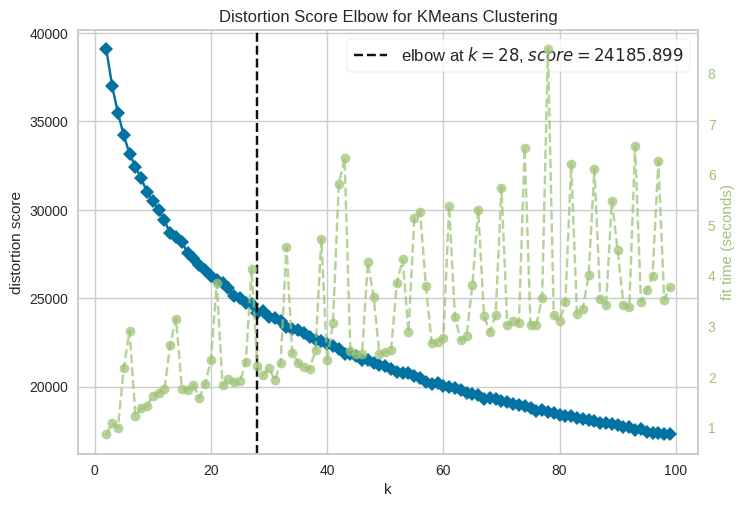

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [126]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,100))
visualizer.fit(X_reduced_train)
visualizer.poof()

With Elbow we can find the ideal number of clusters. The method tells us that the value 33 is the ideal number of clusters. I choose the value 33. When I upload the file here and run it, there may be different values. I found 33 when I did. You accept the k value you see here.

In [127]:
kmeans = KMeans()

In [128]:
cluster = KMeans(n_clusters = 33)
k_fit = kmeans.fit(X_reduced_train)
cluster = k_fit.labels_
cluster

array([2, 5, 2, ..., 4, 3, 0], dtype=int32)

In [129]:
X['cluster'] = cluster

In [130]:
df_all_values_clustered = X.copy()

We say: Person A buys product X with the following features. In the algorithm, it groups people and says: Your characteristics are similar to the person who bought the Y product. You like product

In [131]:
df_all_values_clustered

,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,MPTN_Zipperhead,PCMN_BluishGreen,PCMN_YellowishGreen,SN_DividedAsiakeys,SN_DividedComplementsOther,SN_EQDivided,SN_LadiesOther,SN_MenEdition,SN_MenHMSport,cluster
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,0,0,0,0,0,0,0,0,0,2
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,5
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,2
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,2
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,7
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,4


I am creating DF showing product, number of clusters and number of fetches. I will use it in the estimation phase.

In [132]:
# df_all_values_clustered['']
df_article_cluster = pd.DataFrame({
    'cluster' : df_all_values_clustered['cluster']
})
df_article_cluster = df_article_cluster.reset_index()
df_article_cluster


df_article_cluster = pd.merge(df_article_cluster,df_groupedBuyingArticlesValues.loc[:,['customer_id','article_id']],on='article_id'
                                         ,how='left')
columns = df_article_cluster.columns.tolist()
columns[2] = 'buying_count'
df_article_cluster.columns = columns
df_article_cluster

,article_id,cluster,buying_count
0,685687004,2,98
1,685687001,5,56
2,685687003,2,51
3,673677002,2,29
4,685687002,5,27
...,...,...,...
4898,626815001,7,1
4899,626815002,0,1
4900,626816004,4,1
4901,627009010,3,1


Now I create my Train-Test values to build my model

In [133]:
X = df_all_values_clustered.drop(['cluster'] , axis=1)

In [134]:
y = df_all_values_clustered['cluster']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

print("X_train", X_train.shape)

print("y_train",y_train.shape)

print("X_test",X_test.shape)

print("y_test",y_test.shape)

X_train (3677, 579)
y_train (3677,)
X_test (1226, 579)
y_test (1226,)


In [136]:
X_train

,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,MPTN_Woodballs,MPTN_Zipperhead,PCMN_BluishGreen,PCMN_YellowishGreen,SN_DividedAsiakeys,SN_DividedComplementsOther,SN_EQDivided,SN_LadiesOther,SN_MenEdition,SN_MenHMSport
article_id,,,,,,,,,,,,,,,,,,,,,
610671001,0.05,0.00,0.00,0.08,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
625768001,0.14,0.00,0.00,0.57,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
630116006,0.13,0.00,0.00,0.20,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
555364005,0.10,0.00,0.00,0.38,0.00,0.00,0.00,1.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
272591016,0.06,0.00,0.00,0.11,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537612014,0.04,1.00,1.00,0.62,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
561445006,0.03,0.25,0.25,0.39,1.00,0.00,0.00,0.00,0.75,0.00,...,0,0,0,0,0,0,0,0,0,0
470985003,0.08,1.00,1.00,0.80,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


## Creating Model

I'm Creating a Model. I will be using LightGBM. This is the best fit for my computer in terms of performance.

### LGBMClassifier

In [137]:
from lightgbm import LGBMClassifier
from sklearn.metrics import silhouette_score

In [138]:
lgbm_model = LGBMClassifier().fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 3677, number of used features: 197
[LightGBM] [Info] Start training from score -2.109534
[LightGBM] [Info] Start training from score -2.065667
[LightGBM] [Info] Start training from score -1.627827
[LightGBM] [Info] Start training from score -1.971528
[LightGBM] [Info] Start training from score -2.578641
[LightGBM] [Info] Start training from score -2.125353
[LightGBM] [Info] Start training from score -2.784902
[LightGBM] [Info] Start training from score -1.836533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [139]:
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9730831973898858

### Logitstic Regression

In [140]:
from sklearn.linear_model import LogisticRegression

In [141]:
lg_model = LogisticRegression().fit(X_train, y_train)

In [142]:
lg_y_pred = lg_model.predict(X_test)
accuracy_score(y_test, lg_y_pred)

0.9820554649265906

### Decision Tree

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

In [145]:
dt_y_pred = dt_model.predict(X_test)
accuracy_score(y_test, dt_y_pred)

0.9592169657422512

### Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [147]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [148]:
rf_y_pred = rf_model.predict(X_test)
accuracy_score(y_test, rf_y_pred)

0.9738988580750407

### Convolutional Neural Network

In [149]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [158]:
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
type(X_train)

numpy.ndarray

In [156]:
num_classes = 26

In [159]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

In [160]:
from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [161]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# define the model
model = Sequential()

# add convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=X_train_reshaped.shape[1:], activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1, 1)))

model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# flatten the output from the convolutional layers
model.add(Flatten())

# add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [162]:
# train the model
model.fit(X_train_reshaped, y_train_categorical, validation_data=(X_test_reshaped, y_test_categorical), epochs=10, batch_size=32)

Epoch 1/10
115/115 [==============================] - 18s 145ms/step - loss: 1.0861 - accuracy: 0.6331 - val_loss: 0.1558 - val_accuracy: 0.9502
Epoch 2/10
115/115 [==============================] - 16s 141ms/step - loss: 0.2499 - accuracy: 0.9198 - val_loss: 0.0840 - val_accuracy: 0.9682
Epoch 3/10
115/115 [==============================] - 16s 143ms/step - loss: 0.1583 - accuracy: 0.9470 - val_loss: 0.0816 - val_accuracy: 0.9690
Epoch 4/10
115/115 [==============================] - 16s 141ms/step - loss: 0.1344 - accuracy: 0.9489 - val_loss: 0.0816 - val_accuracy: 0.9706
Epoch 5/10
115/115 [==============================] - 17s 149ms/step - loss: 0.1056 - accuracy: 0.9655 - val_loss: 0.0598 - val_accuracy: 0.9780
Epoch 6/10
115/115 [==============================] - 16s 141ms/step - loss: 0.0989 - accuracy: 0.9644 - val_loss: 0.0837 - val_accuracy: 0.9682
Epoch 7/10
115/115 [==============================] - 16s 141ms/step - loss: 0.0810 - accuracy: 0.9695 - val_loss: 0.0610 - val_ac

### Recurrent Neural Network

In [163]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [164]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# define the model
model = Sequential()

In [170]:
from keras import regularizers
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001, weight_decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
115/115 [==============================] - 4s 12ms/step - loss: 2.0800 - accuracy: 0.4354 - val_loss: 0.7205 - val_accuracy: 0.8809
Epoch 2/50
115/115 [==============================] - 1s 7ms/step - loss: 0.6006 - accuracy: 0.8420 - val_loss: 0.2648 - val_accuracy: 0.9600
Epoch 3/50
115/115 [==============================] - 1s 6ms/step - loss: 0.3470 - accuracy: 0.9171 - val_loss: 0.1848 - val_accuracy: 0.9674
Epoch 4/50
115/115 [==============================] - 1s 6ms/step - loss: 0.2653 - accuracy: 0.9361 - val_loss: 0.1571 - val_accuracy: 0.9698
Epoch 5/50
115/115 [==============================] - 1s 6ms/step - loss: 0.2290 - accuracy: 0.9453 - val_loss: 0.1443 - val_accuracy: 0.9763
Epoch 6/50
115/115 [==============================] - 1s 5ms/step - loss: 0.1943 - accuracy: 0.9568 - val_loss: 0.1331 - val_accuracy: 0.9763
Epoch 7/50
115/115 [==============================] - 1s 5ms/step - loss: 0.1828 - accuracy: 0.9576 - val_loss: 0.1254 - val_accuracy: 0.9796
Epoch

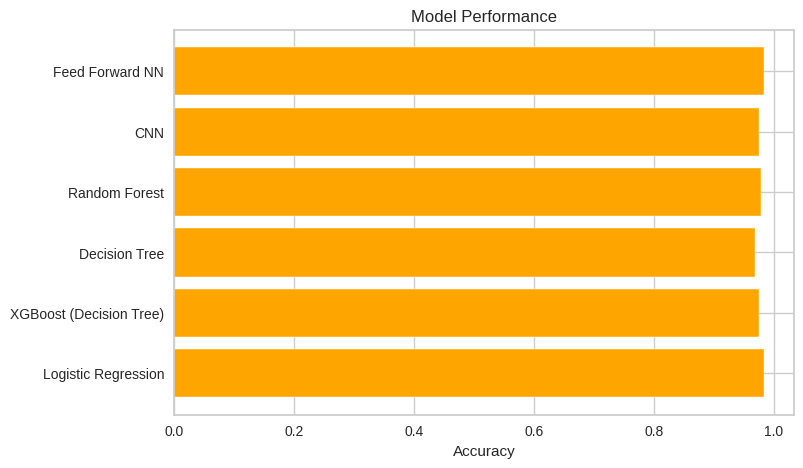

In [171]:
models = ["Logistic Regression","XGBoost (Decision Tree)","Decision Tree","Random Forest","CNN","Feed Forward NN"]
accuracies = [0.983, 0.975, 0.969, 0.979, 0.9755, 0.984]

fig, ax = plt.subplots(figsize=(8, 5))

# Create a horizontal bar chart
ax.barh(models, accuracies, color='orange')

# Set the x-axis label
ax.set_xlabel('Accuracy')

# Set the title
ax.set_title('Model Performance')

# Display the plot
plt.show()

The DFs we have prepared so far.

In [172]:
display(df_TRS_TR_OneCus)
display(df_groupedBuyingArticlesValues)
display(df_oneArticleMost)
display(df_all_values)
display(df_articles_all)
display(df_article_cluster)

,customer_id,articles
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"663713001,541518023"
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,"505221004,685687003,685687004,685687001,505221001"
7,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,"688873012,501323011,598859003,688873020,688873011"
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,"531310002,529841001"
14,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,"501820043,501820043,674681001,671505001,671505..."
...,...,...
9983,365bfd22ce4b8aabeb84c847266a80a225b04f188629bf...,"673677002,636455008"
9985,365d866c4dcfcdf9c7abe4ccd9a0c3beb8e145db7a9524...,"622238007,622238009,622238018"
9988,36689f5d8b67b19a42fff664ad5e39ca4288bc264e72f7...,"657165001,189616008,524939008,610274009,627554..."
9995,366b89e56112858fd747d2b8ec9519b8c7856d34e546eb...,671057002


,article_id,price,customer_id,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,FNF_Regularly
4641,685687004,0.02,98,0.43,0.43,40.99,1.00,0.00,0.00,0.00,0.57,0.00,0.43
4638,685687001,0.02,56,0.41,0.41,38.32,0.96,0.04,0.00,0.00,0.59,0.00,0.41
4640,685687003,0.02,51,0.45,0.45,39.86,0.98,0.02,0.00,0.00,0.55,0.00,0.45
4336,673677002,0.02,29,0.45,0.45,39.97,1.00,0.00,0.00,0.00,0.55,0.00,0.45
4639,685687002,0.02,27,0.41,0.41,37.11,1.00,0.00,0.00,0.00,0.59,0.00,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,626815001,0.03,1,1.00,1.00,53.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2801,626815002,0.03,1,0.00,0.00,35.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
2804,626816004,0.02,1,1.00,1.00,22.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2805,627009010,0.03,1,1.00,0.00,72.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


,article_id,most_prod_name,most_product_type_name,most_product_group_name,most_graphical_appearance_name,most_colour_group_name,most_perceived_colour_value_name,most_perceived_colour_master_name,most_department_name,most_index_name,most_index_group_name,most_section_name,most_garment_group_name
0,663713001,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,541518023,RaePushMelbourne2p,Bra,Underwear,Solid,Pink,DustyLight,Pink,CasualLingerie,LingeriesTights,Ladieswear,WomensLingerie,UnderNightwear
0,505221004,Incajumper,Sweater,GarmentUpperbody,Melange,Pink,MediumDusty,Pink,TopsKnitwearDS,Divided,Divided,DividedSelected,Knitwear
0,685687003,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Melange,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
0,685687004,WYODAKNITOLOFFER,Sweater,GarmentUpperbody,Solid,Black,Dark,Black,Campaigns,Ladieswear,Ladieswear,WomensEverydayCollection,SpecialOffers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,610274009,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,627554001,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,567968002,Heavyjsylongleg,LeggingsTights,GarmentUpperbody,Solid,Black,Dark,Black,YoungGirlJerseyFancy,ChildrenSizes134170,BabyChildren,YoungGirl,JerseyBasic
0,561617003,BoyDenimShorts,Shorts,GarmentLowerbody,Solid,Blue,DustyLight,Blue,Shorts,Divided,Divided,DividedCollection,Shorts


,price,FN,Active,age,CMS_ACTIVE,CMS_UNKNOWN,CMS_LEFT CLUB,CMS_PRE-CREATE,FNF_None,FNF_Monthly,...,MPTN_Woodballs,MPTN_Zipperhead,PCMN_BluishGreen,PCMN_YellowishGreen,SN_DividedAsiakeys,SN_DividedComplementsOther,SN_EQDivided,SN_LadiesOther,SN_MenEdition,SN_MenHMSport
article_id,,,,,,,,,,,,,,,,,,,,,
685687004,0.06,0.43,0.43,0.38,1.00,0.00,0.00,0.00,0.57,0.00,...,0,0,0,0,0,0,0,0,0,0
685687001,0.06,0.41,0.41,0.34,0.96,0.04,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
685687003,0.06,0.45,0.45,0.36,0.98,0.02,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
673677002,0.06,0.45,0.45,0.37,1.00,0.00,0.00,0.00,0.55,0.00,...,0,0,0,0,0,0,0,0,0,0
685687002,0.06,0.41,0.41,0.32,1.00,0.00,0.00,0.00,0.59,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626815001,0.13,1.00,1.00,0.58,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626815002,0.13,0.00,0.00,0.28,1.00,0.00,0.00,0.00,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
626816004,0.09,1.00,1.00,0.07,1.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0


,MPTN_Accessoriesset,MPTN_Aliceband,MPTN_BabyBib,MPTN_Backpack,MPTN_Bag,MPTN_Ballerinas,MPTN_Beanie,MPTN_Belt,MPTN_Bikinitop,MPTN_Blanket,...,GGN_Shorts,GGN_Skirts,GGN_SocksandTights,GGN_SpecialOffers,GGN_Swimwear,GGN_Trousers,GGN_TrousersDenim,GGN_UnderNightwear,GGN_Unknown,GGN_WovenJerseyKnittedmixBaby
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108775051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
110065002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953450001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
953763001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
956217002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,article_id,cluster,buying_count
0,685687004,2,98
1,685687001,5,56
2,685687003,2,51
3,673677002,2,29
4,685687002,5,27
...,...,...,...
4898,626815001,7,1
4899,626815002,0,1
4900,626816004,4,1
4901,627009010,3,1
